In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import community
import time
from random import sample
import random
from itertools import combinations

pd.set_option('display.max_columns', None)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-a8hnv95f because the default path (/home/nlapid/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Loading Datasets

In [2]:
!ls data

'2022 Twitter Accounts Jan-April_Amber Heard Data.csv'
'2022 Twitter daily_creation Jan-April_Amber Heard Data.csv'
'2022 Twitter Tweets Jan-April_Amber Heard Data.csv'
'2022 Twitter users_created_in_2022_Jan-April_Amber Heard Data.csv'
'Figure 4. Central Post.png'
'Tweet network subgraph.png'
 tweets_gc.csv
 tweets_gc_sentiment.csv
'Twitter comments_2022 on Profile Amber Heard.csv'
'User network subgraph.png'


### Accounts, User Creation, Comments

In [3]:
df_accounts = pd.read_csv('data/2022 Twitter Accounts Jan-April_Amber Heard Data.csv',
                          dtype={'user.id_str': object})
df_accounts = df_accounts.drop_duplicates()
display(df_accounts.head())
df_accounts.shape

user.id_str user.screen_name         user.name  \
0  1427358993803005956     StevenJCurry      Steven Curry   
1  1354476984617885703  Vincent72516869         Vincent 1   
2  1076943230657269761     YoonJaysSimp              𝐇𝐘𝐃𝐄   
3           2867834002    blackfire1118  The Film Hipster   
4  1247228236863385600          HTL1998          Harrison   

             user.created_at  \
0  2021-08-16 19:58:03+00:00   
1  2021-01-27 17:11:08+00:00   
2  2018-12-23 20:50:49+00:00   
3  2014-11-08 19:20:40+00:00   
4  2020-04-06 18:22:47+00:00   

                                    user.description  \
0                                                NaN   
1                                        🌮🍕🍔🥪🍳🍤🍜🍛🥟🍰💵   
2  𝐁𝐋 𝐂𝐎𝐍𝐓𝐄𝐍𝐓 • 𝘈𝘯𝘪𝘮𝘦 • 𝘔𝘢𝘯𝘨𝘢 • 𝘔𝘢𝘯𝘩𝘸𝘢 • 𝘕𝘚𝘍𝘞 • 𝘚...   
3                                                NaN   
4  Fan of movies, tv shows, books, and video game...   

                              user.profile_image_url  \
0  http://pbs.twimg.com/profile_images/1429534379...   
1  http://pbs.twimg.com/profile_images/1354614785...   
2  http://pbs.twimg.com/profile_images/1516751870...   
3  http://pbs.twimg.com/profile_images/1400018693...   
4  http://abs.twimg.com/sticky/default_profile_im...   

                             user.profile_banner_url                 user.url  \
0  https://pbs.twimg.com/profile_banners/14273589...                      NaN   
1                                                NaN                      NaN   
2  https://pbs.twimg.com/profile_banners/10769432...  https://t.co/XkBVR5FDCS   
3  https://pbs.twimg.com/profile_banners/28678340...                      NaN   
4                                                NaN                      NaN   

   user.statuses_count  user.followers_count  user.friends_count  
0                199.0                  15.0               139.0  
1               2313.0                  26.0               128.0  
2               5423.0                 120.0               141.0  
3                936.0                  29.0               352.0  
4               1735.0                   6.0                13.0

(182542, 11)

In [4]:
df_creation = pd.read_csv('data/2022 Twitter daily_creation Jan-April_Amber Heard Data.csv')
display(df_creation.head())

user.created_at  user.id_str
0  2022-01-01 00:00:00+00:00           81
1  2022-01-02 00:00:00+00:00           86
2  2022-01-03 00:00:00+00:00          111
3  2022-01-04 00:00:00+00:00           88
4  2022-01-05 00:00:00+00:00          111

In [5]:
df_creation['user.created_at'].astype('datetime64[ns]')

0     2022-01-01
1     2022-01-02
2     2022-01-03
3     2022-01-04
4     2022-01-05
         ...    
113   2022-04-24
114   2022-04-25
115   2022-04-26
116   2022-04-27
117   2022-04-28
Name: user.created_at, Length: 118, dtype: datetime64[ns]

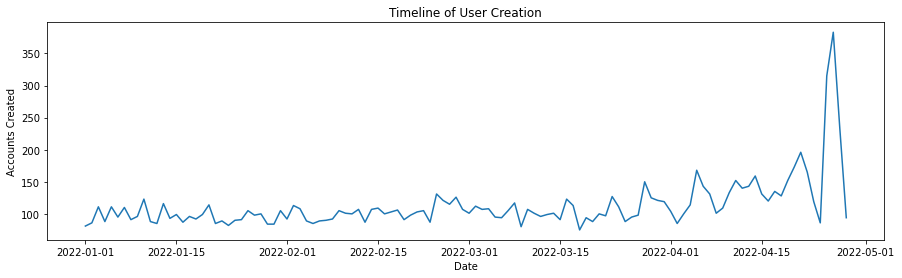

In [6]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(df_creation['user.created_at'].astype('datetime64[ns]'), df_creation['user.id_str'])
ax.set_xlabel('Date')
ax.set_ylabel('Accounts Created')
plt.title('Timeline of User Creation')
plt.show()

In [7]:
df_comments = pd.read_csv('data/Twitter comments_2022 on Profile Amber Heard.csv')
# df_comments = df_comments.drop_duplicates()
display(df_comments.head())
df_comments.shape

author_id                created_at  \
0  1078053002450067456  2022-02-24T21:52:51.000Z   
1  1162470571369783298  2022-02-14T02:01:07.000Z   
2  1078053002450067456  2022-02-14T01:56:23.000Z   
3  1483153757714141186  2022-01-27T00:54:52.000Z   
4  1164240046855086081  2022-02-14T02:17:59.000Z   

                                                text              source  \
0  @realamberheard @ashleyirenebean @mauifilmfest...  Twitter for iPhone   
1  @BakerTheMaker03 @realamberheard @ashleyireneb...  Twitter for iPhone   
2  @realamberheard @ashleyirenebean @mauifilmfest...  Twitter for iPhone   
3  @realamberheard You are the abuser... and he i...     Twitter Web App   
4     @realamberheard @British_Airways Easy af ratio  Twitter for iPhone   

                                   referenced_tweets lang  \
0  [{'type': 'replied_to', 'id': '100932398926350...   en   
1  [{'type': 'replied_to', 'id': '149304140041318...   en   
2  [{'type': 'replied_to', 'id': '100932398926350...   en   
3  [{'type': 'replied_to', 'id': '104723132241287...   en   
4  [{'type': 'replied_to', 'id': '105271849476718...   en   

   in_reply_to_user_id                   id  \
0   807003567605227520  1496966378812698644   
1  1078053002450067456  1493042590106718211   
2   807003567605227520  1493041400413184005   
3   807003567605227520  1486502936511406084   
4   807003567605227520  1493046836533207041   

                                   entities.mentions  \
0  [{'start': 0, 'end': 15, 'username': 'realambe...   
1  [{'start': 0, 'end': 16, 'username': 'BakerThe...   
2  [{'start': 0, 'end': 15, 'username': 'realambe...   
3  [{'start': 0, 'end': 15, 'username': 'realambe...   
4  [{'start': 0, 'end': 15, 'username': 'realambe...   

                                entities.annotations  \
0  [{'start': 236, 'end': 246, 'probability': 0.7...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                           entities.hashtags  public_metrics.retweet_count  \
0  [{'start': 47, 'end': 52, 'tag': 'nfts'}]                             0   
1                                        NaN                             0   
2                                        NaN                             2   
3                                        NaN                             0   
4                                        NaN                             0   

   public_metrics.reply_count  public_metrics.like_count  \
0                           8                          3   
1                           0                          1   
2                           1                         11   
3                           0                          0   
4                           0                          4   

   public_metrics.quote_count  replied_tweet.author_id  \
0                           2       807003567605227520   
1                           0       807003567605227520   
2                           1       807003567605227520   
3                           0       807003567605227520   
4                           1       807003567605227520   

   replied_tweet.created_at  replied_tweet.public_metrics.retweet_count  \
0  2018-06-16T22:27:22.000Z                                          45   
1  2018-06-16T22:27:22.000Z                                          45   
2  2018-06-16T22:27:22.000Z                                          45   
3  2018-10-02T21:06:18.000Z                                          58   
4  2018-10-17T20:17:59.000Z                                           7   

   replied_tweet.public_metrics.reply_count  \
0                                        17   
1                                        17   
2                                        17   
3                                        36   
4                                         5   

   rep

(690, 57)

### Tweets (Main Focus)

In [8]:
df_tweets = pd.read_csv('data/2022 Twitter Tweets Jan-April_Amber Heard Data.csv',
                        dtype={'id_str': object,
                               'in_reply_to_status_id_str': object,
                               'in_reply_to_user_id': object,
                               'user.id_str': object,
                               'user.friends_count': object,
                               'user.lang': object,
                               'user.statuses_count': object,
                               'user.verified': object})

# Cleaning: Some rows don't align with the other rows
df_tweets = df_tweets.drop([458752, 180224, 332638], axis=0)
df_tweets = df_tweets[~df_tweets['user.id_str'].isna()]
df_tweets = df_tweets.drop_duplicates()

display(df_tweets.head())
df_tweets.shape

id_str                 created_at  \
0  1477504983130116096  2022-01-02 05:00:13+00:00   
1  1477503751716065280  2022-01-02 04:55:19+00:00   
2  1477499814719983617  2022-01-02 04:39:41+00:00   
3  1477497740498292738  2022-01-02 04:31:26+00:00   
4  1477496477484212225  2022-01-02 04:26:25+00:00   

                                           full_text lang  \
0  @la77465262 @Melinda15199317 @Dior So why is #...   en   
1  Only thing I want them to leave alone is the f...   en   
2  @soldierboy43001 @ZakReckless Yeah but Snyder ...   en   
3  @IIMissMax @bg98021 @GerberKawasaki You forgot...   en   
4  I never seen Aquaman nor will I because Amber ...   en   

  in_reply_to_status_id_str     in_reply_to_user_id  \
0       1466075642244603909  1.3636309152981484e+18   
1                       NaN                     NaN   
2       1477497121972621318    1.29720483023104e+18   
3       1477475212992073728             305017078.0   
4                       NaN                     NaN   

                               entities.hashtags  \
0  [{'indices': [45, 56], 'text': 'JohnnyDepp'}]   
1                                             []   
2                                             []   
3                                             []   
4                                             []   

                                      entities.media entities.symbols  \
0  [{'original_info': {'width': 1058, 'focus_rect...               []   
1                                                NaN               []   
2                                                NaN               []   
3                                                NaN               []   
4                                                NaN               []   

  entities.urls                             entities.user_mentions  \
0            []  [{'indices': [0, 11], 'screen_name': 'la774652...   
1            []                                                 []   
2            []  [{'indices': [0, 16], 'screen_name': 'soldierb...   
3            []  [{'indices': [0, 10], 'screen_name': 'IIMissMa...   
4            []                                                 []   

                                              source  quoted_status.id_str  \
0  <a href="http://twitter.com/download/android" ...                   NaN   
1  <a href="http://twitter.com/download/iphone" r...          1.477351e+18   
2  <a href="http://twitter.com/download/android" ...                   NaN   
3  <a href="http://twitter.com/download/android" ...                   NaN   
4  <a href="http://twitter.com/download/iphone" r...                   NaN   

         quoted_status.created_at  \
0                             NaN   
1  Sat Jan 01 18:47:47 +0000 2022   
2                             NaN   
3                             NaN   
4                             NaN   

                             quoted_status.full_text quoted_status.lang  \
0                                                NaN                NaN   
1  dceu really just need a HARD reboot like... ht...                 en   
2                                                NaN                NaN   
3                                                NaN                NaN   
4                                                NaN                NaN   

   quoted_status.in_reply_to_status_id_str  quoted_status.in_reply_to_user_id  \
0                                      NaN                                NaN   
1                                      NaN                                NaN   
2                                      NaN                                NaN   
3                                      NaN                                NaN   
4                                      NaN                                NaN   

  quoted_status.entities.hashtags  \
0                             NaN   
1                              []   
2                             NaN   
3                             NaN   
4          

(497288, 39)

## Tweet Reply Network

### Building the Network

In [9]:
df_tweets.head()

id_str                 created_at  \
0  1477504983130116096  2022-01-02 05:00:13+00:00   
1  1477503751716065280  2022-01-02 04:55:19+00:00   
2  1477499814719983617  2022-01-02 04:39:41+00:00   
3  1477497740498292738  2022-01-02 04:31:26+00:00   
4  1477496477484212225  2022-01-02 04:26:25+00:00   

                                           full_text lang  \
0  @la77465262 @Melinda15199317 @Dior So why is #...   en   
1  Only thing I want them to leave alone is the f...   en   
2  @soldierboy43001 @ZakReckless Yeah but Snyder ...   en   
3  @IIMissMax @bg98021 @GerberKawasaki You forgot...   en   
4  I never seen Aquaman nor will I because Amber ...   en   

  in_reply_to_status_id_str     in_reply_to_user_id  \
0       1466075642244603909  1.3636309152981484e+18   
1                       NaN                     NaN   
2       1477497121972621318    1.29720483023104e+18   
3       1477475212992073728             305017078.0   
4                       NaN                     NaN   

                               entities.hashtags  \
0  [{'indices': [45, 56], 'text': 'JohnnyDepp'}]   
1                                             []   
2                                             []   
3                                             []   
4                                             []   

                                      entities.media entities.symbols  \
0  [{'original_info': {'width': 1058, 'focus_rect...               []   
1                                                NaN               []   
2                                                NaN               []   
3                                                NaN               []   
4                                                NaN               []   

  entities.urls                             entities.user_mentions  \
0            []  [{'indices': [0, 11], 'screen_name': 'la774652...   
1            []                                                 []   
2            []  [{'indices': [0, 16], 'screen_name': 'soldierb...   
3            []  [{'indices': [0, 10], 'screen_name': 'IIMissMa...   
4            []                                                 []   

                                              source  quoted_status.id_str  \
0  <a href="http://twitter.com/download/android" ...                   NaN   
1  <a href="http://twitter.com/download/iphone" r...          1.477351e+18   
2  <a href="http://twitter.com/download/android" ...                   NaN   
3  <a href="http://twitter.com/download/android" ...                   NaN   
4  <a href="http://twitter.com/download/iphone" r...                   NaN   

         quoted_status.created_at  \
0                             NaN   
1  Sat Jan 01 18:47:47 +0000 2022   
2                             NaN   
3                             NaN   
4                             NaN   

                             quoted_status.full_text quoted_status.lang  \
0                                                NaN                NaN   
1  dceu really just need a HARD reboot like... ht...                 en   
2                                                NaN                NaN   
3                                                NaN                NaN   
4                                                NaN                NaN   

   quoted_status.in_reply_to_status_id_str  quoted_status.in_reply_to_user_id  \
0                                      NaN                                NaN   
1                                      NaN                                NaN   
2                                      NaN                                NaN   
3                                      NaN                                NaN   
4                                      NaN                                NaN   

  quoted_status.entities.hashtags  \
0                             NaN   
1                              []   
2                             NaN   
3                             NaN   
4          

In [10]:
df_tweet_replies = df_tweets[['id_str', 'in_reply_to_status_id_str']]
df_tweet_nonreplies = df_tweet_replies[df_tweet_replies['in_reply_to_status_id_str'].isna()][['id_str']]
df_tweet_replies = df_tweet_replies.dropna()

display(df_tweet_nonreplies)
display(df_tweet_replies)

id_str
1       1477503751716065280
4       1477496477484212225
5       1477496377865347072
7       1477494128153964544
9       1477492890842587144
...                     ...
508242  1515569901158600704
508243  1515569890391961601
508244  1515569612686970883
508245  1515569604818575368
508246  1515569491513589763

[390367 rows x 1 columns]

id_str in_reply_to_status_id_str
0       1477504983130116096       1466075642244603909
2       1477499814719983617       1477497121972621318
3       1477497740498292738       1477475212992073728
6       1477494226451673094       1477450801413033996
8       1477494112844763141       1477079190365261824
...                     ...                       ...
508229  1515572140896133120       1515384902333739013
508231  1515571529957974018       1515434972903096328
508235  1515570817790189568       1515288513461338112
508238  1515570677943881731       1515035568677158912
508241  1515570192960659460       1515564278417305603

[106921 rows x 2 columns]

**Notes on node/edge attributes:**<br>
No tweet can be posted more than once, and no tweet can reply to another tweet more than once. So using `num_posts` or `num_replies` as node and edge attributes are not applicable.

In [11]:
reply_edges = [(new_post, replied_to) for new_post, replied_to in
               zip(df_tweet_replies['id_str'], df_tweet_replies['in_reply_to_status_id_str'])]

tweet_DG = nx.DiGraph()

for node in df_tweet_nonreplies['id_str']:
    tweet_DG.add_node(node)

for edge in reply_edges:
    tweet_DG.add_edge(edge[0], edge[1])
    
print('Nodes:', len(tweet_DG.nodes()))
print('Edges:', len(tweet_DG.edges()))

Nodes: 553733
Edges: 106921


### Degree Distribution

#### Degrees

In [12]:
tweet_reply_degrees = pd.DataFrame(tweet_DG.degree())
tweet_reply_degrees.columns = ['node', 'degree']
tweet_reply_degrees = tweet_reply_degrees.set_index('node')['degree']
tweet_reply_degrees.sort_values(ascending=False)

node
1483652185757929473    242
1472990607610191872    189
1516846544363917312    163
1514226909873250305    149
1493674927312023553    146
                      ... 
1518906555256684546      0
1518906561518780416      0
1518906572465922050      0
1518906628505931776      0
1516304896794021888      0
Name: degree, Length: 553733, dtype: int64

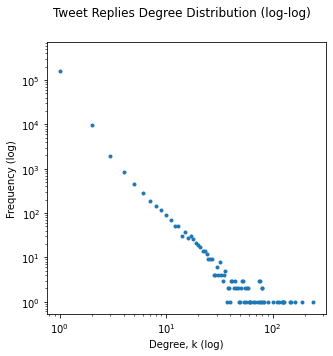

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.loglog(nx.degree_histogram(tweet_DG), '.')
plt.xlabel("Degree, k (log)")
plt.ylabel("Frequency (log)")
plt.suptitle('Tweet Replies Degree Distribution (log-log)')
plt.show()

#### In Degrees

In [14]:
tweet_reply_in_degrees = pd.DataFrame(tweet_DG.in_degree())
tweet_reply_in_degrees.columns = ['node', 'in_degree']
tweet_reply_in_degrees = tweet_reply_in_degrees.set_index('node')['in_degree']
tweet_reply_in_degrees.sort_values(ascending=False)

node
1483652185757929473    242
1472990607610191872    189
1516846544363917312    163
1514226909873250305    149
1493674927312023553    146
                      ... 
1518906555256684546      0
1518906561518780416      0
1518906572465922050      0
1518906628505931776      0
1516304896794021888      0
Name: in_degree, Length: 553733, dtype: int64

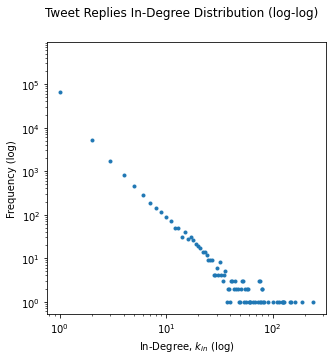

In [15]:
in_degrees = tweet_reply_in_degrees.value_counts(ascending=False).index
in_degree_freqs = tweet_reply_in_degrees.value_counts(ascending=False).values

fig, ax = plt.subplots(figsize=(5, 5))
ax = plt.scatter(in_degrees, in_degree_freqs, marker='.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("In-Degree, $k_{in}$ (log)")
plt.ylabel("Frequency (log)")
plt.suptitle('Tweet Replies In-Degree Distribution (log-log)')
plt.show()

#### Out Degrees

In [16]:
tweet_reply_out_degrees = pd.DataFrame(tweet_DG.out_degree())
tweet_reply_out_degrees.columns = ['node', 'out_degree']
tweet_reply_out_degrees = tweet_reply_out_degrees.set_index('node')['out_degree']
tweet_reply_out_degrees.sort_values(ascending=False)

node
1506877306853277697    1
1513980688143376391    1
1513982783840006153    1
1513982679787741184    1
1513982510618787843    1
                      ..
1519093342579134464    0
1519093346941251584    0
1519093351286554624    0
1519093356617416704    0
1515564278417305603    0
Name: out_degree, Length: 553733, dtype: int64

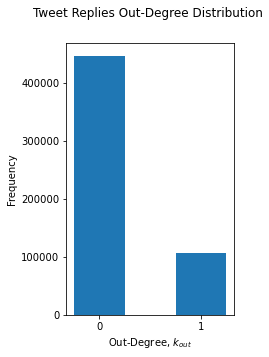

In [17]:
fig, ax = plt.subplots(figsize=(3, 5))

ax.bar(x=[0, 1],
       height=tweet_reply_out_degrees.value_counts(),
       width=0.5)
ax.set_xticks([0, 1])
# .plot(kind='bar')
plt.xlabel("Out-Degree, $k_{out}$")
plt.ylabel("Frequency")
# plt.yscale('log')
plt.suptitle('Tweet Replies Out-Degree Distribution')
plt.show()

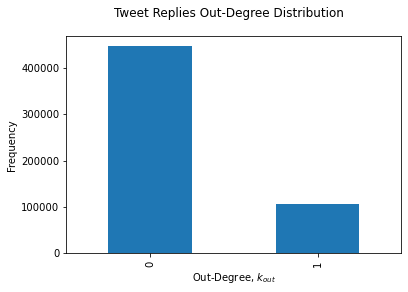

In [18]:
tweet_reply_out_degrees.value_counts().plot(kind='bar')
plt.xlabel("Out-Degree, $k_{out}$")
plt.ylabel("Frequency")
# plt.yscale('log')
plt.suptitle('Tweet Replies Out-Degree Distribution')
plt.show()

It makes sense that the Out Degree Distribution is just binary, since a post can only reply to another post at most once.

### Other Network Stats

#### Of Original Network

Original Network (Complete):
Nodes:  553733
Edges:  106921

Minimum clustering:  0
Maximum clustering:  0
Average clustering:  0.0


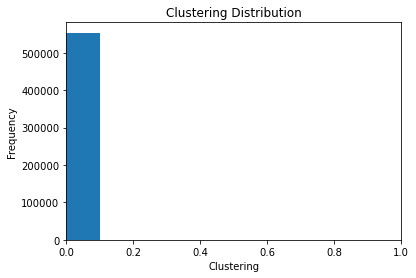

Notes:
Cannot get connectedness of a directed network.
Cannot get distances of an unconnected network.
Network is too big to plot.


In [19]:
N = tweet_DG.order()
L = tweet_DG.size() 

print('Original Network (Complete):')
print ('Nodes: ', N)
print ('Edges: ', L)

clustering = [c for c in nx.clustering(tweet_DG).values()]

c_min = np.min(clustering)
c_max = np.max(clustering);
c_avg = nx.average_clustering(tweet_DG)

print()
print ('Minimum clustering: ', c_min)
print ('Maximum clustering: ', c_max)
print ('Average clustering: ', c_avg)

s_clusters = pd.Series(clustering)

fig, ax = plt.subplots()
s_clusters.plot(kind='hist', ax=ax)
ax.set_xlim(0, 1)
ax.set_xlabel('Clustering')
ax.set_ylabel('Frequency')
plt.title('Clustering Distribution')
plt.show()

print('Notes:')
print('Cannot get connectedness of a directed network.')
print('Cannot get distances of an unconnected network.')
print('Network is too big to plot.')

#### Of Undirected Network

Original Network Converted to Undirected
Nodes:  553733
Edges:  106921
Is Network Connected? False

Minimum clustering:  0
Maximum clustering:  0
Average clustering:  0.0


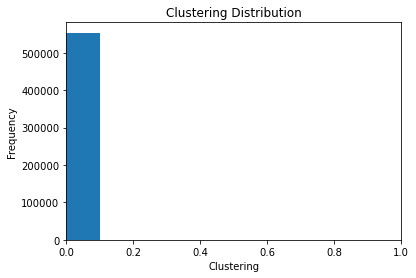

Notes:
Cannot get distances of an unconnected network.
Network is too big to plot.


In [20]:
tweet_G = tweet_DG.to_undirected()

N = tweet_G.order()
L = tweet_G.size() 

print('Original Network Converted to Undirected')
print ('Nodes: ', N)
print ('Edges: ', L)
print('Is Network Connected?', nx.is_connected(tweet_G))

clustering = [c for c in nx.clustering(tweet_G).values()]

c_min = np.min(clustering)
c_max = np.max(clustering);
c_avg = nx.average_clustering(tweet_G)

print()
print ('Minimum clustering: ', c_min)
print ('Maximum clustering: ', c_max)
print ('Average clustering: ', c_avg)

s_clusters = pd.Series(clustering)

fig, ax = plt.subplots()
s_clusters.plot(kind='hist', ax=ax)
ax.set_xlim(0, 1)
ax.set_xlabel('Clustering')
ax.set_ylabel('Frequency')
plt.title('Clustering Distribution')
plt.show()

print('Notes:')
print('Cannot get distances of an unconnected network.')
print('Network is too big to plot.')

#### Of Giant Component (Undirected)

Giant Component (Undirected):
Nodes:  261
Edges:  260
Is Network Connected? True

Minimum clustering:  0
Maximum clustering:  0
Average clustering:  0.0


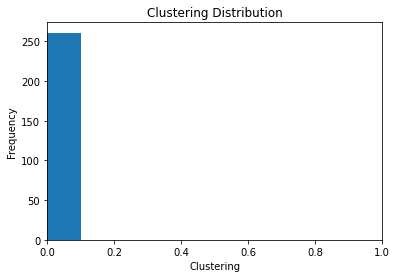


Average Distance:  2.1649277925139994
Diameter:  6


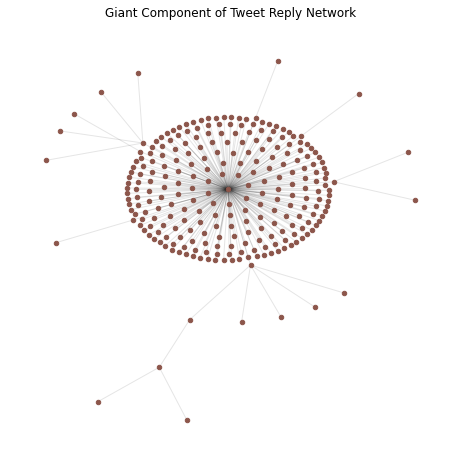

In [21]:
tweet_GC_nodes = max(nx.connected_components(tweet_G), key=len)
tweet_GC = tweet_G.subgraph(tweet_GC_nodes).copy()

N = tweet_GC.order()
L = tweet_GC.size() 


print('Giant Component (Undirected):')
print ('Nodes: ', N)
print ('Edges: ', L)
print('Is Network Connected?', nx.is_connected(tweet_GC))

clustering = [c for c in nx.clustering(tweet_GC).values()]

c_min = np.min(clustering)
c_max = np.max(clustering);
c_avg = nx.average_clustering(tweet_GC)

print()
print ('Minimum clustering: ', c_min)
print ('Maximum clustering: ', c_max)
print ('Average clustering: ', c_avg)

s_clusters = pd.Series(clustering)

fig, ax = plt.subplots()
s_clusters.plot(kind='hist', ax=ax)
ax.set_xlim(0, 1)
ax.set_xlabel('Clustering')
ax.set_ylabel('Frequency')
plt.title('Clustering Distribution')
plt.show()

D = nx.average_shortest_path_length(tweet_GC)
D_max = np.max([list(i.values())
                for i in dict(nx.shortest_path_length(tweet_GC)).values()])

print()
print ('Average Distance: ', D)
print ('Diameter: ', D_max)

pos = nx.kamada_kawai_layout(tweet_GC)
# pos = nx.spring_layout(tweet_GC)
# pos = nx.fruchterman_reingold_layout(tweet_GC)
# pos = nx.circular_layout(tweet_GC)

plt.figure(figsize=(8, 8))

plt.axis("off")
nx.draw_networkx_nodes(tweet_GC, pos, node_size=20, node_color='tab:brown')
nx.draw_networkx_edges(tweet_GC, pos, alpha=0.10)
plt.title(f'Giant Component of Tweet Reply Network')
plt.show()

### Sentiment Analysis

In [22]:
# Get giant component nodes
gc_tweet = list(tweet_GC.nodes())
df_tweets_gc = df_tweets[df_tweets['id_str'].isin(gc_tweet)]

# Save the tweets in a csv file for sentiment analysis notebook
# df_tweets_gc.to_csv('tweets_gc.csv')

In [23]:
# After running Sentiment Analysis on a separate notebook and obtaining the labels
df_tweetsgc_label = pd.read_csv('data/tweets_gc_sentiment.csv', 
                                dtype={'id_str': object}).drop(['Unnamed: 0'], axis=1)
df_tweetsgc_label.head()

id_str                 created_at  \
0  1484418031581233154  2022-01-21 06:50:12+00:00   
1  1484485396167905284  2022-01-21 11:17:53+00:00   
2  1484613837533835264  2022-01-21 19:48:16+00:00   
3  1483753192668151812  2022-01-19 10:48:22+00:00   
4  1483750400880693250  2022-01-19 10:37:16+00:00   

                                           full_text  \
0     watching only the one without amber heard.....   
1   only watching #avatar. love #aquaman2, but ha...   
2   no. my family and friends will not contribute...   
3   nope, won't be watching either. avatar was vi...   
4   chocolate. pirates of the caribbean.  benny a...   

                                           sentiment sentiment_label  \
0  [{'label': 'Neutral', 'score': 0.8662841320037...         Neutral   
1  [{'label': 'Negative', 'score': 0.928562104701...        Negative   
2  [{'label': 'Negative', 'score': 0.693401634693...        Negative   
3  [{'label': 'Negative', 'score': 0.895826995372...        Negative   
4  [{'label': 'Neutral', 'score': 0.8372517824172...         Neutral   

   sentiment_score  
0         0.866284  
1         0.928562  
2         0.693402  
3         0.895827  
4         0.837252

#### Adding of node attributes

In [24]:
# Sentiment Label
df_gc_label = df_tweetsgc_label[['id_str', 'sentiment_label']]
df_gc_label = df_gc_label.set_index('id_str')

# Convert attributes to dict
attrs = df_gc_label.to_dict(orient="index")

# Add node attributes
nx.set_node_attributes(tweet_GC, attrs)

In [25]:
# Number of replies
w_replies = (pd.DataFrame(df_tweets_gc['in_reply_to_status_id_str'].value_counts())
             .reset_index()
             .rename({'index':'id_str', 'in_reply_to_status_id_str':'num_replies'}, axis=1))
w_replies['num_replies'] = w_replies['num_replies'].apply(lambda x: x*50)

df_gc = pd.merge(df_tweets_gc, w_replies, on=['id_str'], how='left')
df_gc['num_replies'] = df_gc['num_replies'].fillna(20)

# Number of replies
df_gc_num = df_gc[['id_str', 'num_replies']]
df_gc_num = df_gc_num.set_index('id_str')

# Convert attributes to dict
attrs = df_gc_num.to_dict(orient="index")

# Add node attributes
nx.set_node_attributes(tweet_GC, attrs)

In [26]:
# Add attributes for the hub
nx.set_node_attributes(tweet_GC, {'1483652185757929473': "Negative"}, name="sentiment_label")
nx.set_node_attributes(tweet_GC, {'1483652185757929473': 700}, name="num_replies")

#### Updated Giant Component Network

Giant Component (Undirected):
Nodes:  261
Edges:  260
Is Network Connected? True

Minimum clustering:  0
Maximum clustering:  0
Average clustering:  0.0


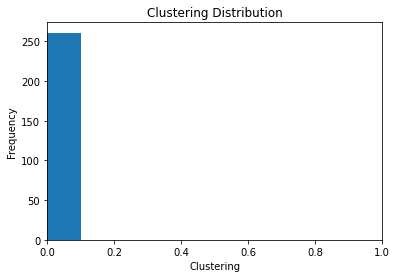


Average Distance:  2.1649277925139994
Diameter:  6


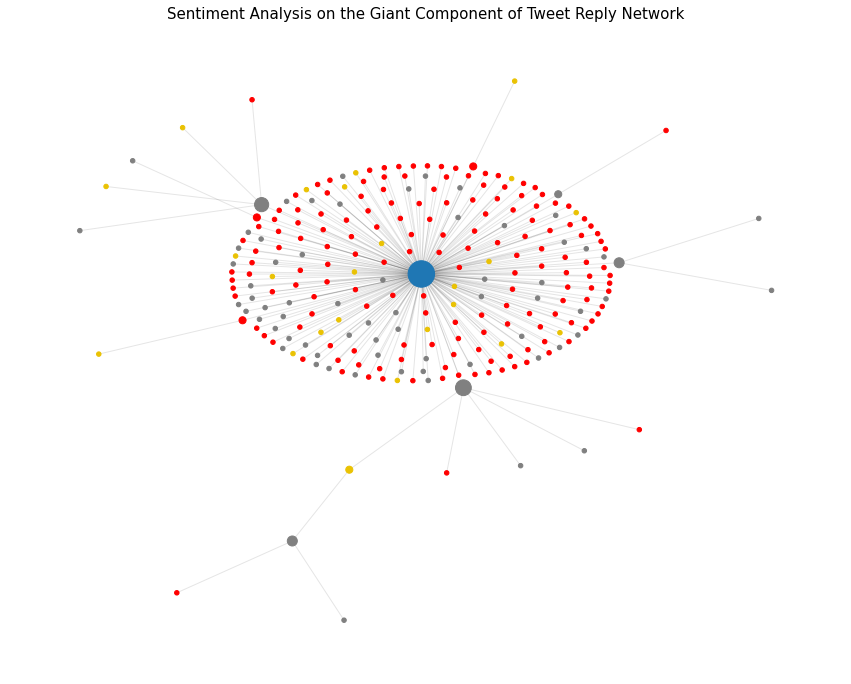

In [27]:
N = tweet_GC.order()
L = tweet_GC.size() 

print('Giant Component (Undirected):')
print ('Nodes: ', N)
print ('Edges: ', L)
print('Is Network Connected?', nx.is_connected(tweet_GC))

clustering = [c for c in nx.clustering(tweet_GC).values()]

c_min = np.min(clustering)
c_max = np.max(clustering);
c_avg = nx.average_clustering(tweet_GC)

print()
print ('Minimum clustering: ', c_min)
print ('Maximum clustering: ', c_max)
print ('Average clustering: ', c_avg)

s_clusters = pd.Series(clustering)

fig, ax = plt.subplots()
s_clusters.plot(kind='hist', ax=ax)
ax.set_xlim(0, 1)
ax.set_xlabel('Clustering')
ax.set_ylabel('Frequency')
plt.title('Clustering Distribution')
plt.show()

D = nx.average_shortest_path_length(tweet_GC)
D_max = np.max([list(i.values())
                for i in dict(nx.shortest_path_length(tweet_GC)).values()])

print()
print ('Average Distance: ', D)
print ('Diameter: ', D_max)

pos = nx.kamada_kawai_layout(tweet_GC)

# Node color is by sentiment label
color = []
for node in tweet_GC.nodes():
    if node == '1483652185757929473':
        color.append("tab:blue")
    elif tweet_GC.nodes.data()[node]['sentiment_label'] == "Negative":
        color.append("red")
    elif tweet_GC.nodes.data()[node]['sentiment_label'] == "Positive":
        color.append("#eac203")
    else:
        color.append("gray")

# Node size is by degree
node_sizes = []
for node in tweet_GC.nodes():
    node_sizes.append(tweet_GC.nodes.data()[node]['num_replies'])
        
plt.figure(figsize=(15, 12))

plt.axis("off")
nx.draw_networkx_nodes(tweet_GC, pos, node_size=node_sizes, node_color=color)
nx.draw_networkx_edges(tweet_GC, pos, alpha=0.10)
plt.title(f'Sentiment Analysis on the Giant Component of Tweet Reply Network', fontsize=15)
plt.show()

### Components (Undirected)

- Component size distribution is similar to the degree distribution because each component just forms around a popular user

Number of components: 446812
Number of components with just 1 node): 376306
Number of components with replies (2 nodes or more): 70506
Mean component size: 1.2392975121527623
Max component size: 261


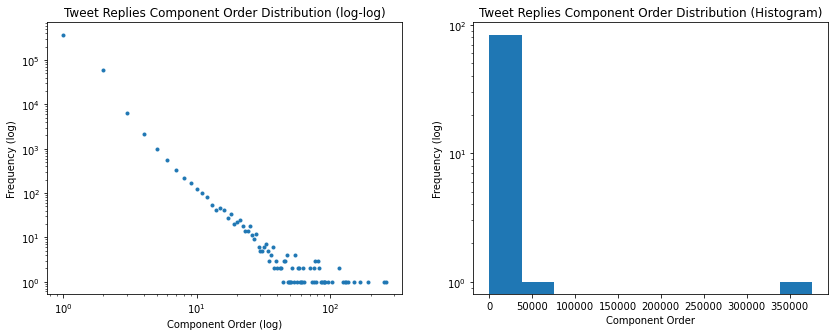

In [28]:
all_component_sizes = pd.Series([len(component) for component in (nx.connected_components(tweet_G))])

component_sizes = all_component_sizes.value_counts().index
component_size_freqs = all_component_sizes.value_counts(ascending=False).values

print('Number of components:', len(all_component_sizes))
print('Number of components with just 1 node):', all_component_sizes.value_counts()[1])
print('Number of components with replies (2 nodes or more):',
      len(all_component_sizes) - all_component_sizes.value_counts()[1])
print('Mean component size:', np.mean(all_component_sizes))
print('Max component size:', np.max(all_component_sizes))

fix, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(component_sizes, component_size_freqs, marker='.')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("Component Order (log)")
ax[0].set_ylabel("Frequency (log)")
ax[0].set_title('Tweet Replies Component Order Distribution (log-log)')

ax[1].hist(all_component_sizes.value_counts().to_numpy())
ax[1].set_yscale('log')
ax[1].set_xlabel("Component Order")
ax[1].set_ylabel("Frequency (log)")
ax[1].set_title('Tweet Replies Component Order Distribution (Histogram)')
plt.show()

In [29]:
all_component_sizes.sort_values(ascending=False).iloc[:30]

393041    261
20320     254
390978    193
156504    166
322397    151
374774    135
361124    131
435914    128
407214    124
40190     116
407465    116
270740    103
207307     96
395365     91
49369      90
408301     89
334629     86
397518     85
404057     82
428955     82
338349     81
404355     81
339758     81
16407      78
409886     77
19557      77
404994     77
414587     76
52667      76
14200      75
dtype: int64

### Subgraph

#### Biggest N components

Components in subgraph: 10
Nodes in subgraph: 1659
Edges in subgraph: 1649


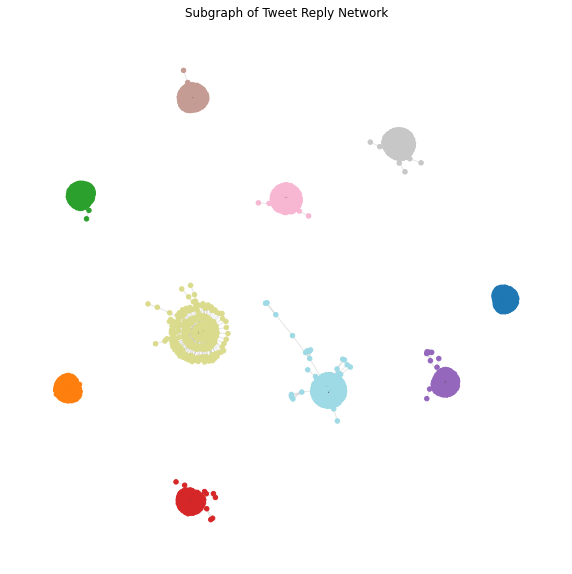

In [30]:
num_components = 10
components = sorted(nx.connected_components(tweet_G), key=len)[-num_components:]

color_dict = {}
subgraph_nodes = []
color = 0
for component in components:
    color += 1 
    for node in component:
        subgraph_nodes.append(node)
        color_dict[node] = color

tweet_subgraph = tweet_G.subgraph(subgraph_nodes).copy()

node_colors = [color_dict[node] for node in tweet_subgraph.nodes()]

print('Components in subgraph:', num_components)
print('Nodes in subgraph:', len(tweet_subgraph.nodes()))
print('Edges in subgraph:', len(tweet_subgraph.edges()))

# pos = nx.kamada_kawai_layout(tweet_subgraph)
# pos = nx.spring_layout(tweet_subgraph)
pos = nx.fruchterman_reingold_layout(tweet_subgraph)
# pos = nx.circular_layout(tweet_subgraph)

plt.figure(figsize=(10, 10))

plt.axis("off")
nx.draw_networkx_nodes(tweet_subgraph, pos, node_size=20,
                       cmap='tab20', node_color=node_colors)
nx.draw_networkx_edges(tweet_subgraph, pos, alpha=0.10)
plt.title(f'Subgraph of Tweet Reply Network')
plt.show()

#### Random N components including some Biggest Components

Components in subgraph: 200
Nodes in subgraph: 3579
Edges in subgraph: 3379


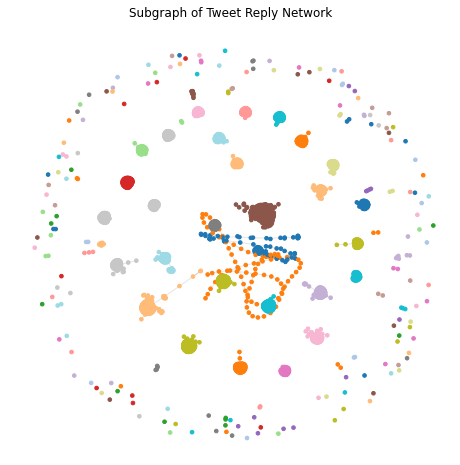

In [31]:
num_components = 200
biggest = 30  # should be greater than 1

random.seed(0)
components = sorted(nx.connected_components(tweet_G), key=len)
components = sample(components[:-biggest], num_components-biggest) + components[-biggest:]
random.shuffle(components)

color_dict = {}
subgraph_nodes = []
color = 0
for component in components:
    color += 1 
    for node in component:
        subgraph_nodes.append(node)
        color_dict[node] = color

tweet_subgraph = tweet_G.subgraph(subgraph_nodes).copy()

node_colors = [color_dict[node] for node in tweet_subgraph.nodes()]
N = len(tweet_subgraph.nodes())
L = len(tweet_subgraph.edges())

print('Components in subgraph:', num_components)
print('Nodes in subgraph:', N)
print('Edges in subgraph:', L)

# pos = nx.kamada_kawai_layout(tweet_subgraph)
# pos = nx.spring_layout(tweet_subgraph)
pos = nx.fruchterman_reingold_layout(tweet_subgraph,
                                     seed=0)
# pos = nx.circular_layout(tweet_subgraph)

plt.figure(figsize=(8, 8))

plt.axis("off")
nx.draw_networkx_nodes(tweet_subgraph, pos, node_size=13,
                       cmap='tab20', node_color=node_colors)
nx.draw_networkx_edges(tweet_subgraph, pos, alpha=0.10)
plt.title(f'Subgraph of Tweet Reply Network')
plt.show()

### Cores

In [33]:
# Core numbers
pd.Series(nx.core_number(tweet_DG)).value_counts().sort_index()

0    376306
1    177427
dtype: int64

In [34]:
print('0-core (original complete network):')
tweet_0core = nx.k_core(tweet_DG, k=0)
print('Nodes:', len(tweet_0core.nodes()))
print('Edges:', len(tweet_0core.edges()))
print('Is Network Connected (if undirected)?',
      nx.is_connected(tweet_0core.to_undirected()))

print()
print('1-core (original reply network):')
tweet_1core = nx.k_core(tweet_DG, k=1)
print('Nodes:', len(tweet_1core.nodes()))
print('Edges:', len(tweet_1core.edges()))
print('Is Network Connected (if undirected)?',
      nx.is_connected(tweet_1core.to_undirected()))

print()
print('2-core:')
tweet_2core = nx.k_core(tweet_DG, k=2)
print('Nodes:', len(tweet_2core.nodes()))
print('Edges:', len(tweet_2core.edges()))

0-core (original complete network):
Nodes: 553733
Edges: 106921
Is Network Connected (if undirected)? False

1-core (original reply network):
Nodes: 177427
Edges: 106921
Is Network Connected (if undirected)? False

2-core:
Nodes: 0
Edges: 0


In [35]:
# Notebook is unable to plot even after 10 hours

# pos = nx.fruchterman_reingold_layout(tweet_1core)

# plt.figure(figsize=(10, 10))

# plt.axis("off")
# nx.draw_networkx_nodes(tweet_1core, pos, node_size=200, node_color='tab:blue')
# nx.draw_networkx_edges(tweet_1core, pos, alpha=0.50)
# nx.draw_networkx_labels(tweet_1core, pos, font_color="black", font_size=11)
# plt.show()

### Communities (Undirected) and Community Size Distribution

- Getting the communities is not as relevant given the fragmented nature of the network, and the radial structure of each component
- Can just use the components as the communities
- Community size distribution is similar to the degree distribution because each community just forms around a popular user

In [36]:
partition = community.best_partition(tweet_G, random_state=0)

print('Number of communities:', len(set(partition.values())))
print('Modularity:', community.modularity(partition, tweet_G))
print('\nNumber of communities and modularity are high due to many isolated nodes.')

Number of communities: 446812
Modularity: 0.9999183036361724

Number of communities and modularity are high due to many isolated nodes.


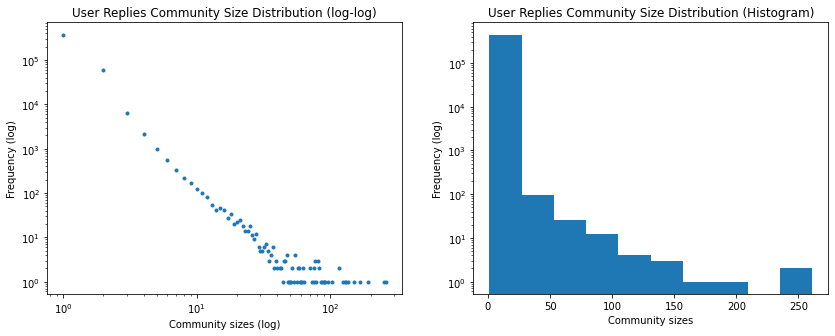

In [37]:
community_size_array = pd.Series(partition).value_counts().values
community_size_value_counts = pd.Series(community_size_array).value_counts()

community_sizes = community_size_value_counts.index
community_size_freqs = community_size_value_counts.values

fix, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(community_sizes, community_size_freqs, marker='.')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("Community sizes (log)")
ax[0].set_ylabel("Frequency (log)")
ax[0].set_title('User Replies Community Size Distribution (log-log)')

ax[1].hist(pd.Series(partition).value_counts().to_numpy())
ax[1].set_yscale('log')
ax[1].set_xlabel("Community sizes")
ax[1].set_ylabel("Frequency (log)")
ax[1].set_title('User Replies Community Size Distribution (Histogram)')
plt.show()

### Centrality

Centrality may not be very relevant, given the fragemented nature of the network and how each component has a radial structure

In [38]:
df_tweet_centrality = pd.DataFrame()
df_tweet_centrality['degree'] = pd.Series(nx.degree_centrality(tweet_DG))
df_tweet_centrality['in_degree'] = pd.Series(nx.in_degree_centrality(tweet_DG))
df_tweet_centrality['out_degree'] = pd.Series(nx.out_degree_centrality(tweet_DG))
df_tweet_centrality['eigenvector'] = pd.Series(nx.eigenvector_centrality(tweet_DG))

# This takes a long time to compute:
# df_tweet_centrality['betweenness'] = pd.Series(nx.betweenness_centrality(tweet_DG))
# df_tweet_centrality['closeness'] = pd.Series(nx.closeness_centrality(tweet_DG))

df_tweet_centrality

degree  in_degree  out_degree   eigenvector
1477503751716065280  0.000000   0.000000    0.000000  7.786610e-14
1477496477484212225  0.000000   0.000000    0.000000  7.786610e-14
1477496377865347072  0.000000   0.000000    0.000000  7.786610e-14
1477494128153964544  0.000000   0.000000    0.000000  7.786610e-14
1477492890842587144  0.000000   0.000000    0.000000  7.786610e-14
...                       ...        ...         ...           ...
1515288513461338112  0.000002   0.000002    0.000000  3.192510e-12
1515570677943881731  0.000002   0.000000    0.000002  7.786610e-14
1515035568677158912  0.000002   0.000002    0.000000  3.192510e-12
1515570192960659460  0.000002   0.000000    0.000002  7.786610e-14
1515564278417305603  0.000002   0.000002    0.000000  3.192510e-12

[553733 rows x 4 columns]

## User Reply Network

### Building the Network

In [39]:
df_user_replies = df_tweets[['user.id_str', 'in_reply_to_user_id']].copy()

# Need this to make formatting of user_id columns consistent
df_user_replies['user.id_str'] = df_user_replies['user.id_str'].astype(float).astype(int)
df_user_nonreplies = df_user_replies[df_user_replies['in_reply_to_user_id'].isna()][['user.id_str']]
df_user_replies = df_user_replies.dropna().astype(float).astype(int)

display(df_user_nonreplies)
display(df_user_replies)

user.id_str
1       1426227152589139968
4       1076943230657269760
5       1186436773104238592
7                 499815801
9       1208864446497591296
...                     ...
508242             27013539
508243  1418420215755517952
508244           3303069384
508245  1319471183016939520
508246           4194755003

[385183 rows x 1 columns]

user.id_str  in_reply_to_user_id
0                 114979514  1363630915298148352
2       1427358993803005952  1297204830231040000
3       1354476984617885696            305017078
6                2867834002  1215458866584006656
8                 106104546  1459581860657471488
...                     ...                  ...
508229  1380912440548937728           1526469709
508231  1305149099751231488           3911239745
508235            230833678           2720077414
508238            305700310           2459083687
508241   806606153367113728  1492510921704415232

[112105 rows x 2 columns]

**Notes on node/edge attributes:**<br>
The following attributes were added:
* `num_posts`: node attribute, number of Amber-related posts by the user within the period. Users with `num_posts=0` were only replied to during the period, but they didnt write posts during the period.
* `num_replies`: edge attribute, number of replies from the replying user to the original poster
* `distance`: edge attribute, reciprocal of `num_replies` representing distance between nodes

In [40]:
user_reply_edges = [(new_post, replied_to) for new_post, replied_to in
                    zip(df_user_replies['user.id_str'], df_user_replies['in_reply_to_user_id'])]

num_posts = dict(df_tweets['user.id_str'].value_counts())
num_posts = {int(i): {'num_posts': j} for i, j in num_posts.items()}

num_replies = dict(pd.Series(user_reply_edges).value_counts())
distances = {i: {'distance': 1/j} for i, j in num_replies.items()}
num_replies = {i: {'num_replies': j} for i, j in num_replies.items()}

user_DG = nx.DiGraph()

for node in df_user_nonreplies['user.id_str']:
    user_DG.add_node(node)

for edge in user_reply_edges:
    user_DG.add_edge(edge[0], edge[1])

nx.set_node_attributes(user_DG, 0, "num_posts")  # set 0 as default num_posts
nx.set_node_attributes(user_DG, num_posts)       # update num_posts for users who posted
nx.set_edge_attributes(user_DG, num_replies)
nx.set_edge_attributes(user_DG, distances)

# Remove self-loops
user_DG.remove_edges_from(nx.selfloop_edges(user_DG))
    
print('Nodes:', len(user_DG.nodes()))
print('Edges:', len(user_DG.edges()))

Nodes: 203498
Edges: 81321


### Degree Distribution

#### Degrees

In [41]:
user_reply_degrees = pd.DataFrame(user_DG.degree())
user_reply_degrees.columns = ['node', 'degree']
user_reply_degrees = user_reply_degrees.set_index('node')['degree']
user_reply_degrees.sort_values(ascending=False)

node
44196397               1308
1329510487952924672     863
775355256410701824      557
901030183213445120      549
20255162                471
                       ... 
1379870978793205760       0
311663610                 0
1492281503325298688       0
1214741720589467648       0
1426227152589139968       0
Name: degree, Length: 203498, dtype: int64

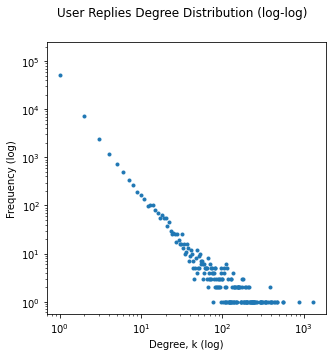

In [42]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.loglog(nx.degree_histogram(user_DG), '.')
plt.xlabel("Degree, k (log)")
plt.ylabel("Frequency (log)")
plt.suptitle('User Replies Degree Distribution (log-log)')
plt.show()

#### In Degrees

In [43]:
user_reply_in_degrees = pd.DataFrame(user_DG.in_degree())
user_reply_in_degrees.columns = ['node', 'in_degree']
user_reply_in_degrees = user_reply_in_degrees.set_index('node')['in_degree']
user_reply_in_degrees.sort_values(ascending=False)

node
44196397              1308
775355256410701824     547
901030183213445120     544
20255162               471
3309371255             454
                      ... 
742933440555798528       0
80051904                 0
2988294944               0
860404394705268736       0
260106647                0
Name: in_degree, Length: 203498, dtype: int64

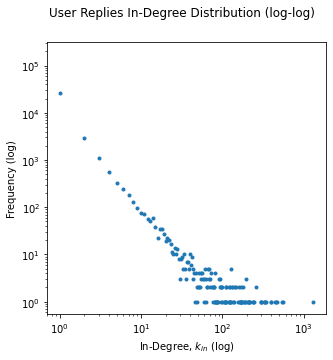

In [44]:
in_degrees = user_reply_in_degrees.value_counts(ascending=False).index
in_degree_freqs = user_reply_in_degrees.value_counts(ascending=False).values

fix, ax = plt.subplots(figsize=(5, 5))
ax = plt.scatter(in_degrees, in_degree_freqs, marker='.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("In-Degree, $k_{in}$ (log)")
plt.ylabel("Frequency (log)")
plt.suptitle('User Replies In-Degree Distribution (log-log)')
plt.show()

#### Out Degrees

In [45]:
user_reply_out_degrees = pd.DataFrame(user_DG.out_degree())
user_reply_out_degrees.columns = ['node', 'out_degree']
user_reply_out_degrees = user_reply_out_degrees.set_index('node')['out_degree']
user_reply_out_degrees.sort_values(ascending=False)

node
1329510487952924672    816
1236499544440844288    385
1118256911089131520    377
1288453155290673152    365
1194347545578950656    358
                      ... 
1341236785708457984      0
832905357269880832       0
1336045460730097664      0
987855746971983872       0
1492510921704415232      0
Name: out_degree, Length: 203498, dtype: int64

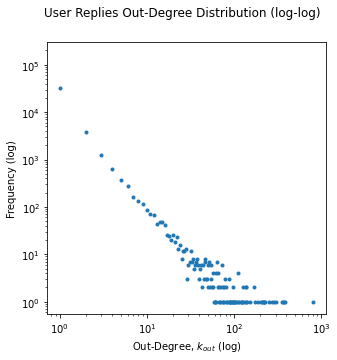

In [46]:
out_degrees = user_reply_out_degrees.value_counts(ascending=False).index
out_degree_freqs = user_reply_out_degrees.value_counts(ascending=False).values

fix, ax = plt.subplots(figsize=(5, 5))
ax = plt.scatter(out_degrees, out_degree_freqs, marker='.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Out-Degree, $k_{out}$ (log)")
plt.ylabel("Frequency (log)")
plt.suptitle('User Replies Out-Degree Distribution (log-log)')
plt.show()

### Other Network Stats

#### Of Original Network

Original Network (Complete):
Nodes:  203498
Edges:  81321

Minimum clustering:  0.0
Maximum clustering:  1.0
Average clustering:  0.0014312392050547802


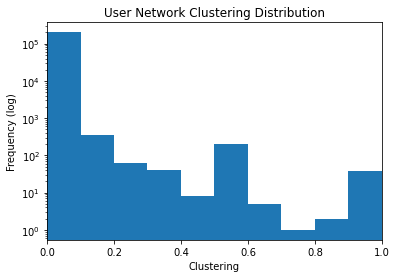

Notes:
Cannot get connectedness of a directed network.
Cannot get distances of an unconnected network.
Network is too big to plot.


In [47]:
N = user_DG.order()
L = user_DG.size() 

print('Original Network (Complete):')
print ('Nodes: ', N)
print ('Edges: ', L)

clustering = [c for c in nx.clustering(user_DG).values()]

c_min = np.min(clustering)
c_max = np.max(clustering);
c_avg = nx.average_clustering(user_DG)

print()
print ('Minimum clustering: ', c_min)
print ('Maximum clustering: ', c_max)
print ('Average clustering: ', c_avg)

s_clusters = pd.Series(clustering)

fig, ax = plt.subplots()
s_clusters.plot(kind='hist', ax=ax)
ax.set_xlim(0, 1)
ax.set_xlabel('Clustering')
ax.set_ylabel('Frequency (log)')
plt.yscale('log')
plt.title('User Network Clustering Distribution')
plt.show()

print('Notes:')
print('Cannot get connectedness of a directed network.')
print('Cannot get distances of an unconnected network.')
print('Network is too big to plot.')

#### Of Undirected Network

Original Network Converted to Undirected
Nodes:  203498
Edges:  80226
Is Network Connected? False

Minimum clustering:  0.0
Maximum clustering:  1.0
Average clustering:  0.002511479175531275


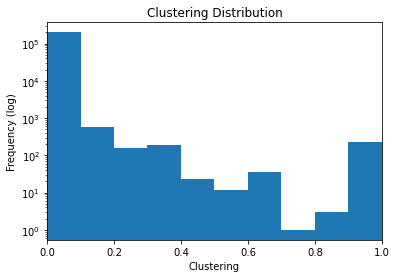

Notes:
Cannot get distances of an unconnected network.
Network is too big to plot.


In [48]:
user_G = user_DG.to_undirected()

N = user_G.order()
L = user_G.size() 

print('Original Network Converted to Undirected')
print ('Nodes: ', N)
print ('Edges: ', L)
print('Is Network Connected?', nx.is_connected(user_G))

clustering = [c for c in nx.clustering(user_G).values()]

c_min = np.min(clustering)
c_max = np.max(clustering);
c_avg = nx.average_clustering(user_G)

print()
print ('Minimum clustering: ', c_min)
print ('Maximum clustering: ', c_max)
print ('Average clustering: ', c_avg)

s_clusters = pd.Series(clustering)

fig, ax = plt.subplots()
s_clusters.plot(kind='hist', ax=ax)
ax.set_xlim(0, 1)
ax.set_xlabel('Clustering')
ax.set_ylabel('Frequency (log)')
plt.yscale('log')
plt.title('Clustering Distribution')
plt.show()

print('Notes:')
print('Cannot get distances of an unconnected network.')
print('Network is too big to plot.')

#### Of Giant Component (Undirected)

Giant Component (Undirected):
Nodes:  32183
Edges:  61042
Is Network Connected? True

Minimum clustering:  0.0
Maximum clustering:  1.0
Average clustering:  0.01520723122752995


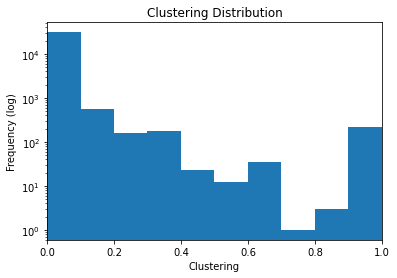

Giant component is too big to plot or get distances.


In [49]:
user_GC_nodes = max(nx.connected_components(user_G), key=len)
user_GC = user_G.subgraph(user_GC_nodes).copy()

N = user_GC.order()
L = user_GC.size() 

print('Giant Component (Undirected):')
print ('Nodes: ', N)
print ('Edges: ', L)
print('Is Network Connected?', nx.is_connected(user_GC))

clustering = [c for c in nx.clustering(user_GC).values()]

c_min = np.min(clustering)
c_max = np.max(clustering);
c_avg = nx.average_clustering(user_GC)

print()
print ('Minimum clustering: ', c_min)
print ('Maximum clustering: ', c_max)
print ('Average clustering: ', c_avg)

s_clusters = pd.Series(clustering)

fig, ax = plt.subplots()
s_clusters.plot(kind='hist', ax=ax)
ax.set_xlim(0, 1)
ax.set_xlabel('Clustering')
ax.set_ylabel('Frequency (log)')
plt.yscale('log')
plt.title('Clustering Distribution')
plt.show()

print('Giant component is too big to plot or get distances.')

In [50]:
# This takes a long time, given the size of the network

# D = nx.average_shortest_path_length(user_GC)
# D_max = np.max([list(i.values())
#                 for i in dict(nx.shortest_path_length(user_GC)).values()])

# print()
# print ('Average Distance: ', D)
# print ('Diameter: ', D_max)

# pos = nx.kamada_kawai_layout(tweet_GC)
# # pos = nx.spring_layout(tweet_GC)
# # pos = nx.fruchterman_reingold_layout(tweet_GC)
# # pos = nx.circular_layout(tweet_GC)

# plt.figure(figsize=(8, 8))

# plt.axis("off")
# nx.draw_networkx_nodes(user_GC, pos, node_size=20, node_color='tab:blue')
# nx.draw_networkx_edges(user_GC, pos, alpha=0.10)
# plt.title(f'Giant Component of User Reply Network')
# plt.show()

### Components (Undirected)

- Coponent size distribution is similar to the degree distribution because each component just forms around a popular user
- The major outlier is the giant component, which appears more interconnected. Unfortunately it's hard to plot

Number of components: 152145
Number of components with just 1 node): 137183
Number of components with replies (2 nodes or more): 14962
Mean component size: 1.3375267015018568
Max component size: 32183


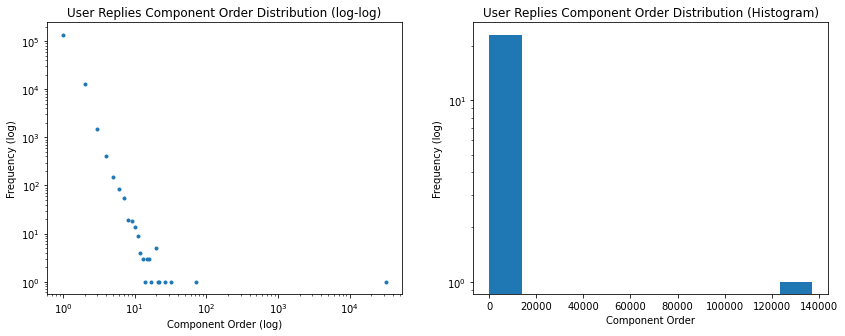

In [51]:
all_component_sizes = pd.Series([len(component) for component in (nx.connected_components(user_G))])

component_sizes = all_component_sizes.value_counts().index
component_size_freqs = all_component_sizes.value_counts(ascending=False).values

print('Number of components:', len(all_component_sizes))
print('Number of components with just 1 node):', all_component_sizes.value_counts()[1])
print('Number of components with replies (2 nodes or more):',
      len(all_component_sizes) - all_component_sizes.value_counts()[1])
print('Mean component size:', np.mean(all_component_sizes))
print('Max component size:', np.max(all_component_sizes))

fix, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(component_sizes, component_size_freqs, marker='.')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("Component Order (log)")
ax[0].set_ylabel("Frequency (log)")
ax[0].set_title('User Replies Component Order Distribution (log-log)')

ax[1].hist(all_component_sizes.value_counts().to_numpy())
ax[1].set_yscale('log')
ax[1].set_xlabel("Component Order")
ax[1].set_ylabel("Frequency (log)")
ax[1].set_title('User Replies Component Order Distribution (Histogram)')
plt.show()

In [52]:
all_component_sizes.sort_values(ascending=False)

2        32183
18110       72
87853       32
73777       26
10284       22
         ...  
51944        1
51945        1
51946        1
51947        1
76072        1
Length: 152145, dtype: int64

### Subgraph

#### Biggest N components (except Giant Component)

Components in subgraph: 100
Nodes in subgraph: 1142
Edges in subgraph: 1046


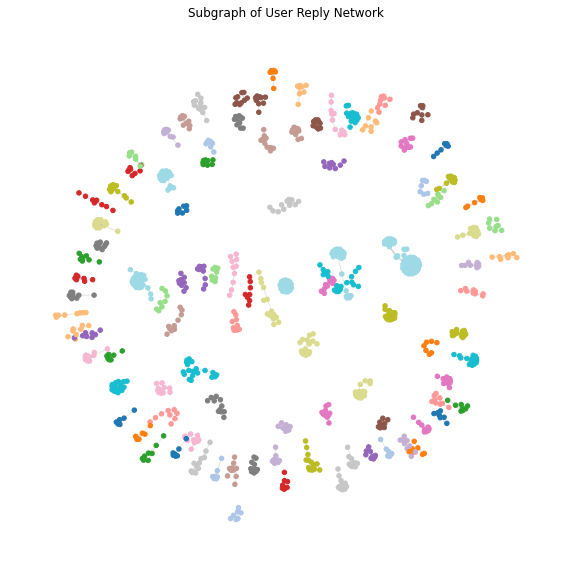

In [53]:
# Note this excludes the giant component, which is too large to plot.

num_components = 100
components = sorted(nx.connected_components(user_G), key=len)[-(num_components + 1):-1]

color_dict = {}
subgraph_nodes = []
color = 0
for component in components:
    color += 1 
    for node in component:
        subgraph_nodes.append(node)
        color_dict[node] = color

user_subgraph = user_G.subgraph(subgraph_nodes).copy()
node_colors = [color_dict[node] for node in user_subgraph.nodes()]

print('Components in subgraph:', num_components)
print('Nodes in subgraph:', len(user_subgraph.nodes()))
print('Edges in subgraph:', len(user_subgraph.edges()))

# pos = nx.kamada_kawai_layout(user_subgraph)
# pos = nx.spring_layout(user_subgraph)
pos = nx.fruchterman_reingold_layout(user_subgraph)
# pos = nx.circular_layout(user_subgraph)

plt.figure(figsize=(10, 10))

plt.axis("off")
nx.draw_networkx_nodes(user_subgraph, pos, node_size=20,
                       cmap ='tab20', node_color=node_colors)
nx.draw_networkx_edges(user_subgraph, pos, alpha=0.10)
plt.title(f'Subgraph of User Reply Network')
plt.show()

#### Random N Components inclduding second-biggest component

Components in subgraph: 200
Nodes in subgraph: 288
Edges in subgraph: 90


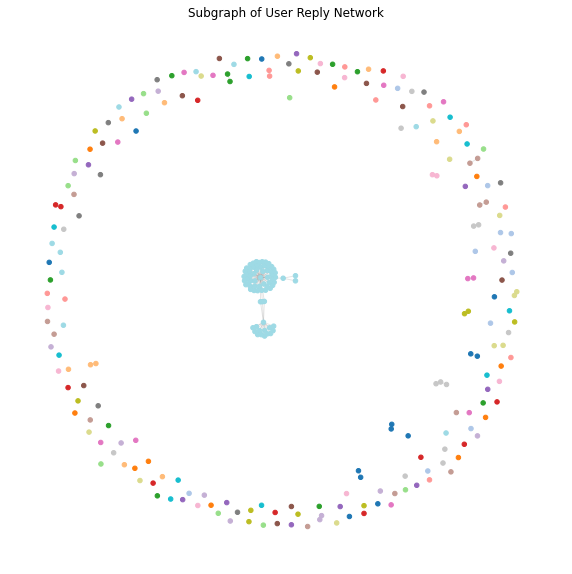

In [54]:
# Note this excludes the giant component, which is too large to plot.

num_components = 200
components = sorted(nx.connected_components(user_G), key=len)
components = sample(components, num_components - 1) + [components[-2]]

color_dict = {}
subgraph_nodes = []
color = 0
for component in components:
    color += 1 
    for node in component:
        subgraph_nodes.append(node)
        color_dict[node] = color

user_subgraph = user_G.subgraph(subgraph_nodes).copy()
node_colors = [color_dict[node] for node in user_subgraph.nodes()]

print('Components in subgraph:', num_components)
print('Nodes in subgraph:', len(user_subgraph.nodes()))
print('Edges in subgraph:', len(user_subgraph.edges()))

# pos = nx.kamada_kawai_layout(user_subgraph)
# pos = nx.spring_layout(user_subgraph)
pos = nx.fruchterman_reingold_layout(user_subgraph)
# pos = nx.circular_layout(user_subgraph)

plt.figure(figsize=(10, 10))

plt.axis("off")
nx.draw_networkx_nodes(user_subgraph, pos, node_size=20,
                       cmap ='tab20', node_color=node_colors)
nx.draw_networkx_edges(user_subgraph, pos, alpha=0.10)
plt.title(f'Subgraph of User Reply Network')
plt.show()

#### Random N Components

Components in subgraph: 200
Nodes in subgraph: 213
Edges in subgraph: 13


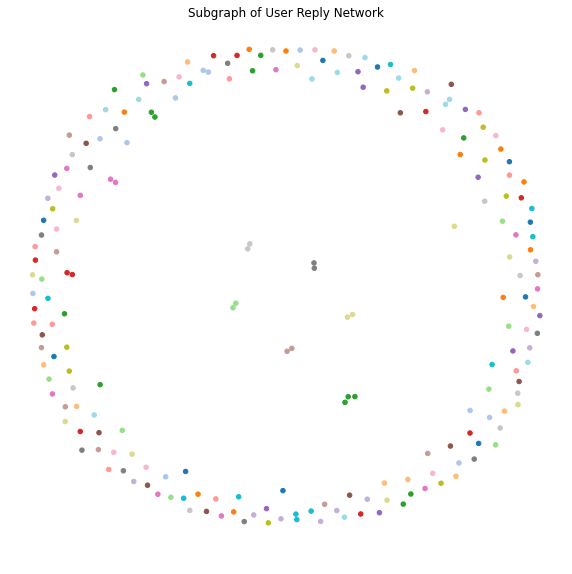

In [55]:
# Note this excludes the giant component, which is too large to plot.

num_components = 200
components = sorted(nx.connected_components(user_G), key=len)
components = sample(components, num_components)

color_dict = {}
subgraph_nodes = []
color = 0
for component in components:
    color += 1 
    for node in component:
        subgraph_nodes.append(node)
        color_dict[node] = color

user_subgraph = user_G.subgraph(subgraph_nodes).copy()
node_colors = [color_dict[node] for node in user_subgraph.nodes()]

print('Components in subgraph:', num_components)
print('Nodes in subgraph:', len(user_subgraph.nodes()))
print('Edges in subgraph:', len(user_subgraph.edges()))

# pos = nx.kamada_kawai_layout(user_subgraph)
# pos = nx.spring_layout(user_subgraph)
pos = nx.fruchterman_reingold_layout(user_subgraph)
# pos = nx.circular_layout(user_subgraph)

plt.figure(figsize=(10, 10))

plt.axis("off")
nx.draw_networkx_nodes(user_subgraph, pos, node_size=20,
                       cmap ='tab20', node_color=node_colors)
nx.draw_networkx_edges(user_subgraph, pos, alpha=0.10)
plt.title(f'Subgraph of User Reply Network')
plt.show()

### Cores

In [56]:
# Core numbers
pd.Series(nx.core_number(user_DG)).value_counts().sort_index()

0     137183
1      57239
2       4894
3       1305
4        696
5        403
6        280
7        202
8        178
9        123
10       114
11        96
12        80
13        77
14        66
15        43
16        45
17        44
18        60
19        39
20        35
21        25
22        19
23        20
24        35
25        29
26        48
27       120
dtype: int64

In [57]:
print('0-core (original complete network):')
user_0core = nx.k_core(user_DG, k=0)
print('Nodes:', len(user_0core.nodes()))
print('Edges:', len(user_0core.edges()))
print('Is Network Connected (if undirected)?',
      nx.is_connected(user_0core.to_undirected()))

print()
print('1-core (original reply network):')
user_1core = nx.k_core(user_DG, k=1)
print('Nodes:', len(user_1core.nodes()))
print('Edges:', len(user_1core.edges()))
print('Is Network Connected (if undirected)?',
      nx.is_connected(user_1core.to_undirected()))

print()
print('2-core:')
user_2core = nx.k_core(user_DG, k=2)
print('Nodes:', len(user_2core.nodes()))
print('Edges:', len(user_2core.edges()))
print('Is Network Connected (if undirected)?',
      nx.is_connected(user_2core.to_undirected()))

for i in range(5, 26, 5):
    print()
    print(f'{i}-core')
    user_kcore = nx.k_core(user_DG, k=i)
    print('Nodes:', len(user_kcore.nodes()))
    print('Edges:', len(user_kcore.edges()))
    print('Is Network Connected (if undirected)?',
          nx.is_connected(user_kcore.to_undirected()))
    
user_kcore = nx.k_core(user_DG)
k_max = pd.Series(nx.core_number(user_kcore)).max()
print()
print(f'{k_max}-core (main core)')
print('Nodes:', len(user_kcore.nodes()))
print('Edges:', len(user_kcore.edges()))
print('Is Network Connected (if undirected)?',
      nx.is_connected(user_kcore.to_undirected()))

0-core (original complete network):
Nodes: 203498
Edges: 81321
Is Network Connected (if undirected)? False

1-core (original reply network):
Nodes: 66315
Edges: 81321
Is Network Connected (if undirected)? False

2-core:
Nodes: 9076
Edges: 38796
Is Network Connected (if undirected)? False

5-core
Nodes: 2181
Edges: 23751
Is Network Connected (if undirected)? True

10-core
Nodes: 995
Edges: 16246
Is Network Connected (if undirected)? True

15-core
Nodes: 562
Edges: 11214
Is Network Connected (if undirected)? True

20-core
Nodes: 331
Edges: 7324
Is Network Connected (if undirected)? True

25-core
Nodes: 197
Edges: 4425
Is Network Connected (if undirected)? True

27-core (main core)
Nodes: 120
Edges: 2488
Is Network Connected (if undirected)? True


In [58]:
# kernel dies at k=2
# k = 2

# user_kcore = nx.k_core(user_DG, k=k)
# print(f'{k}-core')
# print('Nodes:', len(user_kcore.nodes()))
# print('Edges:', len(user_kcore.edges()))

# pos = nx.kamada_kawai_layout(user_kcore)
# # pos = nx.spring_layout(user_kcore)
# # pos = nx.fruchterman_reingold_layout(user_kcore)
# # pos = nx.circular_layout(user_kcore)

# plt.figure(figsize=(10, 10))

# plt.axis("off")
# nx.draw_networkx_nodes(user_kcore, pos, node_size=20, node_color='tab:blue')
# nx.draw_networkx_edges(user_kcore, pos, alpha=0.10)
# # nx.draw_networkx_labels(user_kcore, pos, font_color="black", font_size=11)
# plt.title(f'k-core (k={k}) of user reply network')
# plt.show()

10-core
Nodes: 995
Edges: 16246


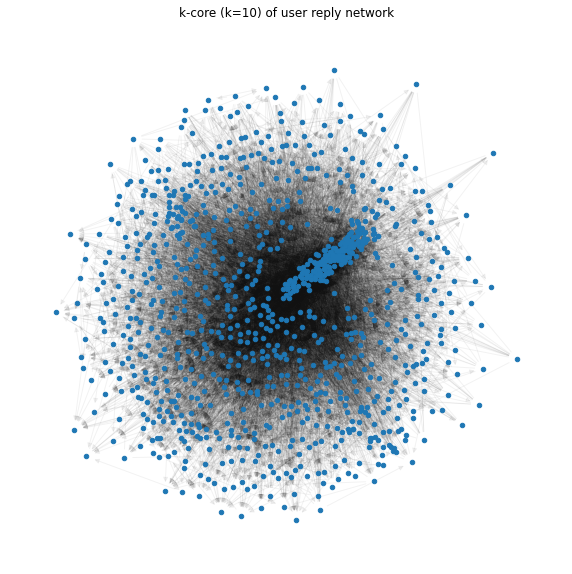

In [59]:
k = 10

user_kcore = nx.k_core(user_DG, k=k)
print(f'{k}-core')
print('Nodes:', len(user_kcore.nodes()))
print('Edges:', len(user_kcore.edges()))

pos = nx.kamada_kawai_layout(user_kcore)
# pos = nx.spring_layout(user_kcore)
# pos = nx.fruchterman_reingold_layout(user_kcore)
# pos = nx.circular_layout(user_kcore)

plt.figure(figsize=(10, 10))

plt.axis("off")
nx.draw_networkx_nodes(user_kcore, pos, node_size=20, node_color='tab:blue')
nx.draw_networkx_edges(user_kcore, pos, alpha=0.05)
# nx.draw_networkx_labels(user_kcore, pos, font_color="black", font_size=11)
plt.title(f'k-core (k={k}) of user reply network')
plt.show()

27-core
Nodes: 120
Edges: 2488


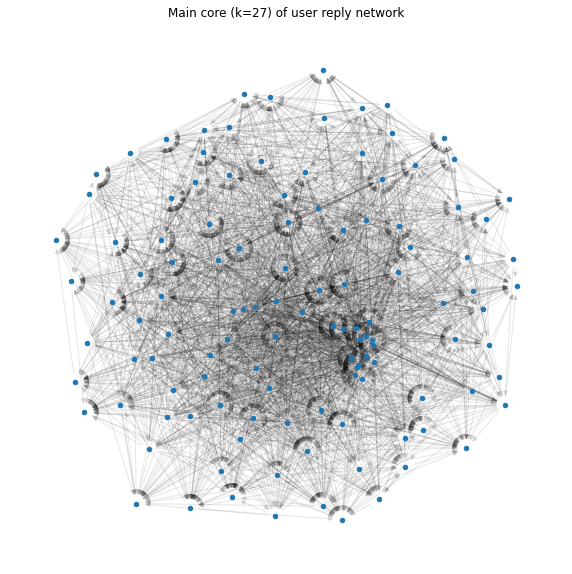

In [60]:
k = 27

user_maxcore = nx.k_core(user_DG, k=k)
print(f'{k}-core')
print('Nodes:', len(user_maxcore.nodes()))
print('Edges:', len(user_maxcore.edges()))

pos = nx.kamada_kawai_layout(user_maxcore)
# pos = nx.spring_layout(user_maxcore)
# pos = nx.fruchterman_reingold_layout(user_maxcore)
# pos = nx.circular_layout(user_maxcore)

plt.figure(figsize=(10, 10))

plt.axis("off")
nx.draw_networkx_nodes(user_maxcore, pos, node_size=20, node_color='tab:blue')
nx.draw_networkx_edges(user_maxcore, pos, alpha=0.10)
# nx.draw_networkx_labels(user_maxcore, pos, font_color="black", font_size=11)
plt.title(f'Main core (k={k}) of user reply network')
plt.show()

### Plot combining k-core and components

Components in subgraph: 200
Nodes in subgraph: 1911
Edges in subgraph: 16562


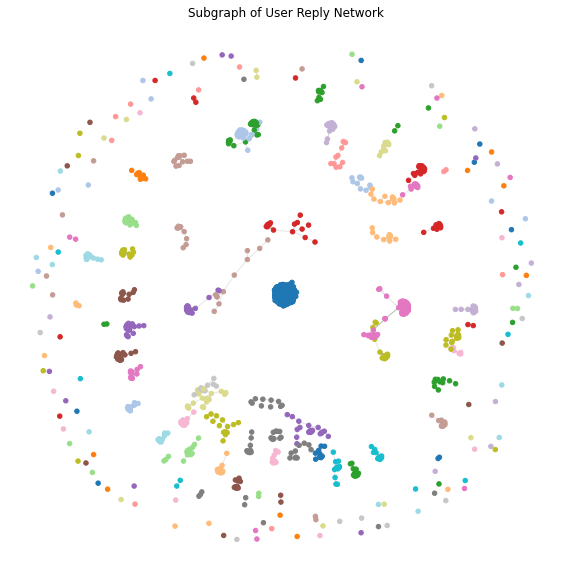

In [61]:
# Note this excludes the giant component, which is too large to plot.

num_components = 200
biggest = 50  # should be greater than 1
random.seed(0)
components = sorted(nx.connected_components(user_G), key=len)
components = sample(components[:-biggest-1], num_components-biggest) + components[-biggest-1:-1]
random.shuffle(components)

color_dict = {}
subgraph_nodes = []
color = 0
for component in components:
    color += 1 
    for node in component:
        subgraph_nodes.append(node)
        color_dict[node] = color
        
for node in user_kcore.nodes():
    subgraph_nodes.append(node)
    color_dict[node] = 0

user_subgraph = user_G.subgraph(subgraph_nodes).copy()
node_colors = [color_dict[node] for node in user_subgraph.nodes()]

print('Components in subgraph:', num_components)
print('Nodes in subgraph:', len(user_subgraph.nodes()))
print('Edges in subgraph:', len(user_subgraph.edges()))

# pos = nx.kamada_kawai_layout(user_subgraph)
pos = nx.spring_layout(user_subgraph)
# pos = nx.fruchterman_reingold_layout(user_subgraph)
# pos = nx.circular_layout(user_subgraph)

plt.figure(figsize=(10, 10))

plt.axis("off")
nx.draw_networkx_nodes(user_subgraph, pos, node_size=20,
                       cmap ='tab20', node_color=node_colors)
nx.draw_networkx_edges(user_subgraph, pos, alpha=0.10)
plt.title(f'Subgraph of User Reply Network')
plt.show()

### Communities (Undirected) and Community Size Distribution

- Realized late that getting the communities is somewhat pointless given the fragmented nature of the network, and the radial structure of each component. We can just use the components as the communities
- The exception perhaps is for the communities in the Giant Component which is hard to plot
- Community size distribution is similar to the degree distribution because each community just forms around a popular user (again, except for the GC which may be more interconnected)

#### Communities are derived from the original network
* The number of replies is used as a weight in deriving the communities
* A k-core is used just for graphing purposes
* Should us a subgraph for graphing purposes instead

Original Network:
Nodes: 203498
Edges: 81321
Number of communities in the original network: 152381
Modularity: 0.7173354581573588

10-core
Nodes: 995
Edges: 15842
Is the 10-core Connected? True
Number of communities included in the 10-core: 34


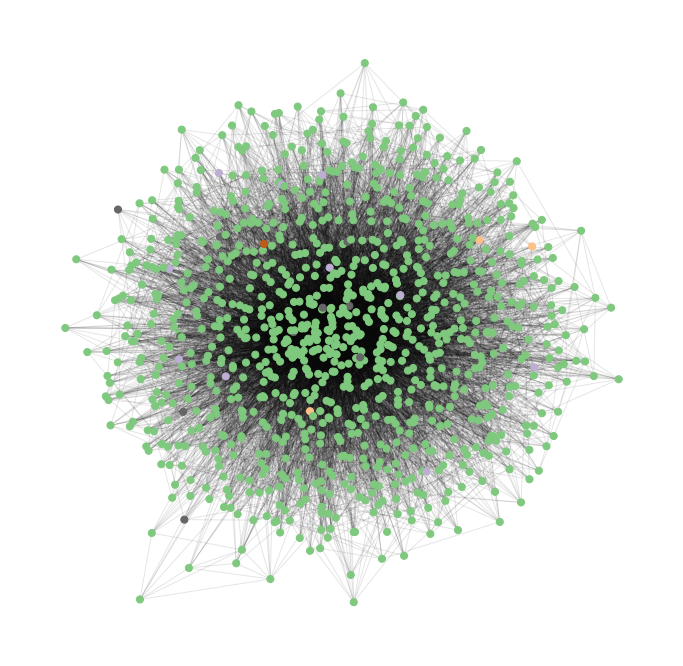

In [62]:
# Choose a value for k:
k = 10

partition = community.best_partition(user_G, weight='num_replies', random_state=0)

user_kcore = nx.k_core(user_DG, k=k).to_undirected()
node_colors = [community for node, community in partition.items() if node in user_kcore.nodes()]

print('Original Network:')
print('Nodes:', len(user_DG.nodes()))
print('Edges:', len(user_DG.edges()))
print('Number of communities in the original network:', len(set(partition.values())))
print('Modularity:', community.modularity(partition, user_G))

print(f'\n{k}-core')
print('Nodes:', len(user_kcore.nodes()))
print('Edges:', len(user_kcore.edges()))
print(f'Is the {k}-core Connected?', nx.is_connected(user_kcore.to_undirected()))
print(f'Number of communities included in the {k}-core:', len(pd.Series(node_colors).value_counts()))

# pos = nx.kamada_kawai_layout(user_kcore)
# pos = nx.fruchterman_reingold_layout(user_kcore)
pos = nx.spring_layout(user_kcore)
# pos = nx.circular_layout(user_kcore)

plt.figure(figsize=(12,12));
plt.axis("off");
nx.draw_networkx_nodes(user_kcore, pos, node_size=50, cmap='Accent',
                       node_color=node_colors)
nx.draw_networkx_edges(user_kcore, pos, alpha=0.10)
# nx.draw_networkx_labels(G_sub, pos, labels=partition,
#                         font_color="white", font_size=8)
plt.show()

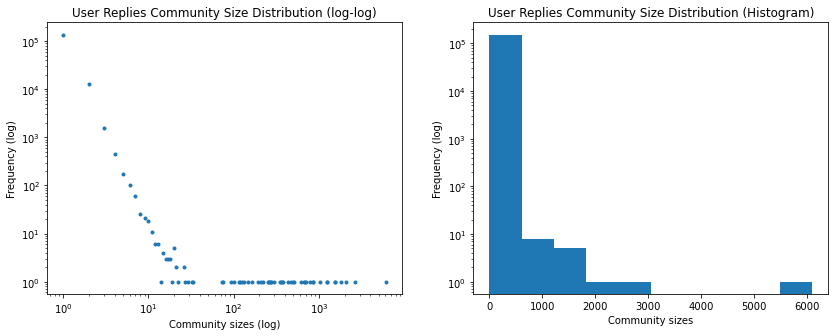

In [63]:
community_size_array = pd.Series(partition).value_counts().values
community_size_value_counts = pd.Series(community_size_array).value_counts()

community_sizes = community_size_value_counts.index
community_size_freqs = community_size_value_counts.values

fix, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(community_sizes, community_size_freqs, marker='.')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("Community sizes (log)")
ax[0].set_ylabel("Frequency (log)")
ax[0].set_title('User Replies Community Size Distribution (log-log)')

ax[1].hist(pd.Series(partition).value_counts().to_numpy())
ax[1].set_yscale('log')
ax[1].set_xlabel("Community sizes")
ax[1].set_ylabel("Frequency (log)")
ax[1].set_title('User Replies Community Size Distribution (Histogram)')
plt.show()

#### Communities are derived directly from the k-core

* The plots are prettier, but I'm not sure whether this approach is valid?
* Again, the number of replies is used as a weight when deriving the communities

10-core
Nodes: 995
Edges: 15842
Is Network Connected (if undirected)? True

Number of communities: 8
Modularity: 0.15807176061817746


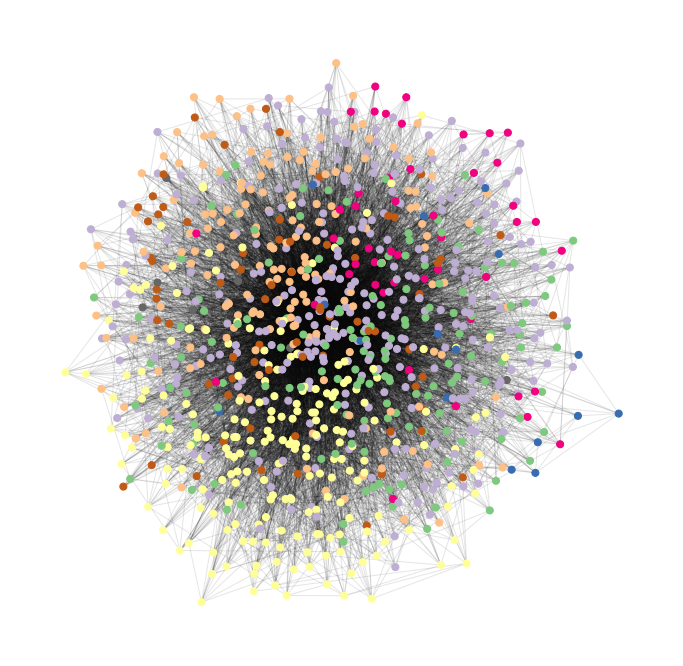

In [64]:
# Choose a value for k:
k = 10
user_kcore = nx.k_core(user_DG, k=k).to_undirected()
kcore_partition = community.best_partition(user_kcore, weight='num_replies', random_state=0)

print(f'{k}-core')
print('Nodes:', len(user_kcore.nodes()))
print('Edges:', len(user_kcore.edges()))
print('Is Network Connected (if undirected)?',
      nx.is_connected(user_kcore.to_undirected()))
print('\nNumber of communities:', len(set(kcore_partition.values())))
print('Modularity:', community.modularity(kcore_partition, user_kcore))

# pos = nx.kamada_kawai_layout(user_kcore)
pos = nx.fruchterman_reingold_layout(user_kcore)
# pos = nx.spring_layout(user_kcore)
# pos = nx.circular_layout(user_kcore)

plt.figure(figsize=(12,12));
plt.axis("off");
nx.draw_networkx_nodes(user_kcore, pos, node_size=50, cmap='Accent',
                       node_color=list(kcore_partition.values()))
nx.draw_networkx_edges(user_kcore, pos, alpha=0.10)
# nx.draw_networkx_labels(G_sub, pos, labels=partition,
#                         font_color="white", font_size=8)
plt.show()

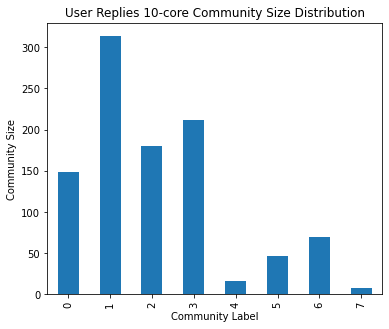

In [65]:
fig, ax = plt.subplots(figsize=(6, 5))

pd.Series(kcore_partition).value_counts().sort_index().plot(kind='bar')
plt.title(f'User Replies {k}-core Community Size Distribution')
plt.xlabel('Community Label')
plt.ylabel('Community Size')
plt.show()

#### Communities are derived from the Giant Component

In [96]:
gc_partition = community.best_partition(user_GC, weight='num_replies', randomize=False, random_state=0)

print(f'Giant Component')
print('Nodes:', len(user_GC.nodes()))
print('Edges:', len(user_GC.edges()))
print('Is Network Connected (if undirected)?',
      nx.is_connected(user_GC.to_undirected()))
print('\nNumber of communities:', len(set(gc_partition.values())))
print('Modularity:', community.modularity(gc_partition, user_GC))

# # GC is too big to plot

# # pos = nx.kamada_kawai_layout(user_GC)
# pos = nx.fruchterman_reingold_layout(user_GC)
# # pos = nx.spring_layout(user_GC)
# # pos = nx.circular_layout(user_GC)

# plt.figure(figsize=(12,12));
# plt.axis("off");
# nx.draw_networkx_nodes(user_GC, pos, node_size=50, cmap='Accent',
#                        node_color=list(gc_partition.values()))
# nx.draw_networkx_edges(user_GC, pos, alpha=0.10)
# # nx.draw_networkx_labels(user_GC, pos, labels=partition,
# #                         font_color="white", font_size=8)
# plt.show()

Giant Component
Nodes: 32183
Edges: 61042
Is Network Connected (if undirected)? True

Number of communities: 267
Modularity: 0.5907166417370541


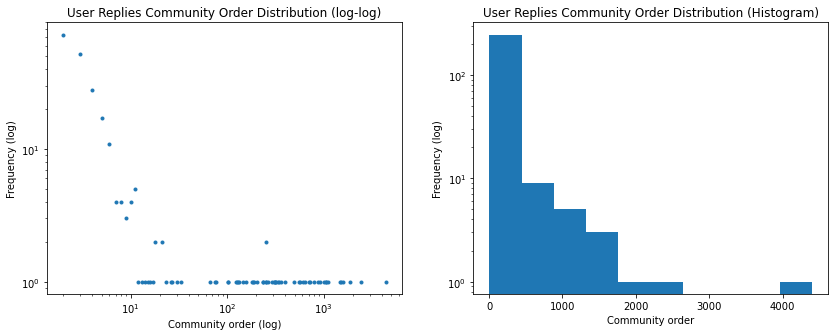

In [67]:
community_size_array = pd.Series(gc_partition).value_counts().values
community_size_value_counts = pd.Series(community_size_array).value_counts()

community_sizes = community_size_value_counts.index
community_size_freqs = community_size_value_counts.values

fix, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(community_sizes, community_size_freqs, marker='.')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("Community order (log)")
ax[0].set_ylabel("Frequency (log)")
ax[0].set_title('User Replies Community Order Distribution (log-log)')

ax[1].hist(pd.Series(gc_partition).value_counts().to_numpy())
ax[1].set_yscale('log')
ax[1].set_xlabel("Community order")
ax[1].set_ylabel("Frequency (log)")
ax[1].set_title('User Replies Community Order Distribution (Histogram)')
plt.show()

#### Largest Community (or nth Largest Community) derived from Giant Component

Largest Community  of Giant Component:
Nodes:  4403
Edges:  13779
Is Network Connected? True

Minimum clustering:  0.0
Maximum clustering:  1.0
Average clustering:  0.06340251823458332


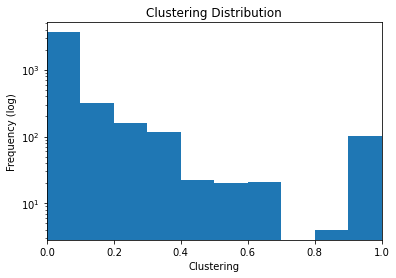


Average Distance:  3.5927786834861157
Diameter:  8

Largest community still seems too big to plot.


In [68]:
largest_comm = pd.Series(gc_partition).value_counts().sort_values(ascending=False).index[0]
comm_nodes = [node for node, comm in dict(gc_partition).items() if comm==largest_comm]

user_GC_subgraph = user_GC.subgraph(comm_nodes).copy()

N = user_GC_subgraph.order()
L = user_GC_subgraph.size() 

print('Largest Community  of Giant Component:')
print ('Nodes: ', N)
print ('Edges: ', L)
print('Is Network Connected?', nx.is_connected(user_GC_subgraph))

clustering = [c for c in nx.clustering(user_GC_subgraph).values()]

c_min = np.min(clustering)
c_max = np.max(clustering);
c_avg = nx.average_clustering(user_GC_subgraph)

print()
print ('Minimum clustering: ', c_min)
print ('Maximum clustering: ', c_max)
print ('Average clustering: ', c_avg)

s_clusters = pd.Series(clustering)

fig, ax = plt.subplots()
s_clusters.plot(kind='hist', ax=ax)
ax.set_xlim(0, 1)
ax.set_xlabel('Clustering')
ax.set_ylabel('Frequency (log)')
plt.yscale('log')
plt.title('Clustering Distribution')
plt.show()

D = nx.average_shortest_path_length(user_GC_subgraph)
D_max = np.max([list(i.values())
                for i in dict(nx.shortest_path_length(user_GC_subgraph)).values()])

print()
print('Average Distance: ', D)
print('Diameter: ', D_max)

print('\nLargest community still seems too big to plot.')
# pos = nx.kamada_kawai_layout(user_GC_subgraph)
# # pos = nx.spring_layout(user_GC_subgraph)
# # pos = nx.fruchterman_reingold_layout(user_GC_subgraph)
# # pos = nx.circular_layout(user_GC_subgraph)

# plt.figure(figsize=(10, 10))

# plt.axis("off")
# nx.draw_networkx_nodes(user_GC_subgraph, pos, node_size=20, node_color='tab:blue')
# nx.draw_networkx_edges(user_GC_subgraph, pos, alpha=0.10)
# plt.title(f'Largest Community in Giant Component of User Reply Network')
# plt.show()

##### Examining communities based on user opinion

In [69]:
#Binning of Users based on hashtags
tweet_hashtags = df_tweets['entities.hashtags'].str.findall(r"'text': '(\w+)'")
df_tweets['hashtags'] = tweet_hashtags

s = df_tweets.groupby('user.id_str')['hashtags'].sum().apply(set)
df = s.to_frame()
df = df.reset_index()
johnny = {'JusticeForJohnnyDepp', 'JusticeForJohnnyDepp', 'AmberHeardIsTheRealAbuser',
         'AmberHeardIsALiar', 'AmberHeardIsAnAbuser', 'AmberHeard', 'JusticeForJohnnyDeppVirginia2022',
         'JohnnyDeppIsInnocent', 'AmberTurd', 'JohnnyDeppVsAmberHeard', 'justiceforjohnnydepp',
         'johnnydepp', 'JohnnyDeppDeservesJustice', 'IStandWithJohnnyDepp', 'JusticeforJohnnyDepp',
         'JusticeForJohhnyDepp', 'MenToo', 'AbuseHasNoGender', 'MePoo', 'AquamanAndTheLostKingdom',
         'JohnnyDepptrial', 'JusticeForJohnnyDeep', 'DeppVsHeard', 'NeverFearTruth',
         'AmberHeardDeservesPrison', 'JusticeForJohnnyDeppVA2022', 'DeppWarriorsGroupHug',
         'Minamata', 'IStandWithAmberHeard', 'Sweepstakes', 'OscarsFanFavorite', 'johnnydeppisinnocent',
         'johnny', 'Johnny', 'Depp', 'AmberHeardsWeaselLawyers', 'AMBERLIED', 'NotJustMen', 'WhyDidShehavetocomealong',
         'deppthejohnny', 'johnnythedepp', 'AmberHeardIsAnAbuser', 'Johnnydepp', 'JohnnyDeppDeservesJustice',
         'JusticeForJohnnyDepp2022', 'JohnnyDeppDeservesJustice', 'IBelieveYouJohnnyDepp', 'JohnnyDeppDeservesJustice',
         'IBelieveJohnnyDepp', 'WeAreWithJohnnyDepp', 'IBelieveJohnnyDepp'}

amber = {'JohnnyDeppisawifebeater', 'HappyBirthdayAmberHeard', 'IStandWithAmberHeard',
        'misogyny', 'JUSTICEFORAMBERHEARD', 'JohnnyDeppIsAnAbuser', 'JohnnyDeppisarapist',
        'freeamberheard', 'MentalHealthAwarenessMonth', 'justiceforamberheard',
        'FuckJohnnyDepp', 'JohnnyDeppIsAWifeBeater', 'JohnnyDeppisanabuser'}

df['johnny'] = df["hashtags"].apply(lambda x: '' if x.isdisjoint(johnny) else 'johnny')
df["amber"] = df["hashtags"].apply(lambda x: '' if x.isdisjoint(amber) else 'amber')
df["no_hashtag"] = df["hashtags"].apply(lambda x: 'no_hashtag' if len(x)==0 else '')
df['neutral'] = df["hashtags"].apply(lambda x: 'neutral' if (x.isdisjoint(johnny) and x.isdisjoint(amber) and len(x)>0) else '')
df['hashtag_bin'] = df['johnny'] + df['amber'] + df['no_hashtag'] + df['neutral']
df['hashtag_bin'] = df['hashtag_bin'].replace({'johnnyamber': 'both'})
df = df.drop(columns=['johnny', 'amber', 'no_hashtag', 'neutral'])

In [70]:
user_color_dict = {'no_hashtag': 'gray', 'amber': 'red', 'johnny': 'blue', 'both': 'black', 'neutral': '#CCAC93'}
df_users = df.copy()
df_users = df_users.set_index('user.id_str')
users_final_color_dict = df_users['hashtag_bin'].map(user_color_dict).to_dict()
users_final_color_dict = {int(k):str(v) for k,v in users_final_color_dict.items()}

12th Largest Community of Giant Component:
Nodes:  879
Edges:  915
Is Network Connected? True

Minimum clustering:  0.0
Maximum clustering:  1.0
Average clustering:  0.00696707888985971


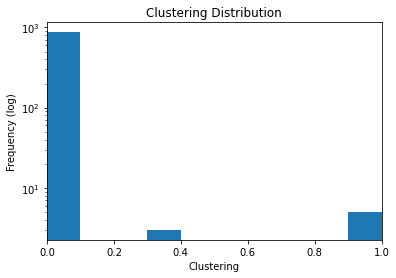


Average Distance:  5.959409766223266
Diameter:  19


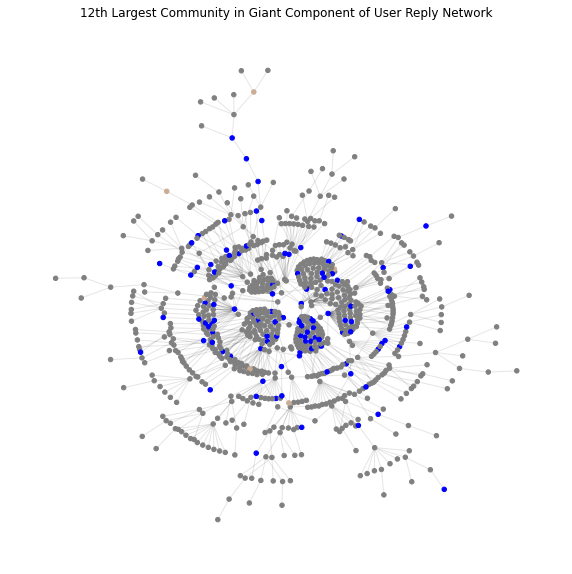

In [71]:
# Choose n, representing the nth largest community in the User network GC
n = 12

nth_comm = pd.Series(gc_partition).value_counts().sort_values(ascending=False).index[n-1]
comm_nodes = [node for node, comm in dict(gc_partition).items() if comm==nth_comm]

user_GC_subgraph = user_GC.subgraph(comm_nodes).copy()

users_giant_comp_list = list(user_GC_subgraph.nodes())
users_final_list = list(users_final_color_dict)
users_node_colors = []

for i in users_giant_comp_list:
    if i not in users_final_list:
        users_node_colors.append('gray')
    else:
        users_node_colors.append(users_final_color_dict[i])


N = user_GC_subgraph.order()
L = user_GC_subgraph.size() 

print(f'{n}th Largest Community of Giant Component:')
print ('Nodes: ', N)
print ('Edges: ', L)
print('Is Network Connected?', nx.is_connected(user_GC_subgraph))

clustering = [c for c in nx.clustering(user_GC_subgraph).values()]

c_min = np.min(clustering)
c_max = np.max(clustering);
c_avg = nx.average_clustering(user_GC_subgraph)

print()
print ('Minimum clustering: ', c_min)
print ('Maximum clustering: ', c_max)
print ('Average clustering: ', c_avg)

s_clusters = pd.Series(clustering)

fig, ax = plt.subplots()
s_clusters.plot(kind='hist', ax=ax)
ax.set_xlim(0, 1)
ax.set_xlabel('Clustering')
ax.set_ylabel('Frequency (log)')
plt.yscale('log')
plt.title('Clustering Distribution')
plt.show()

D = nx.average_shortest_path_length(user_GC_subgraph)
D_max = np.max([list(i.values())
                for i in dict(nx.shortest_path_length(user_GC_subgraph)).values()])

print()
print ('Average Distance: ', D)
print ('Diameter: ', D_max)

pos = nx.kamada_kawai_layout(user_GC_subgraph)
# pos = nx.spring_layout(user_GC_subgraph)
# pos = nx.fruchterman_reingold_layout(user_GC_subgraph)
# pos = nx.circular_layout(user_GC_subgraph)

plt.figure(figsize=(10, 10))

plt.axis("off")
nx.draw_networkx_nodes(user_GC_subgraph, pos, node_size=20, node_color=users_node_colors)
nx.draw_networkx_edges(user_GC_subgraph, pos, alpha=0.10)
plt.title(f'{n}th Largest Community in Giant Component of User Reply Network')
plt.show()

5th Largest Community of Giant Component:
Nodes:  1508
Edges:  1513
Is Network Connected? True

Minimum clustering:  0.0
Maximum clustering:  1.0
Average clustering:  0.0011715317249699762


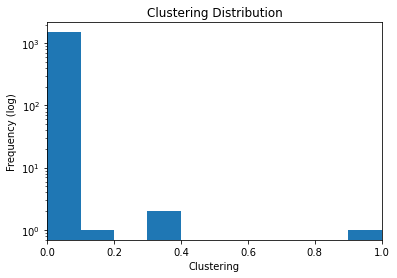


Average Distance:  2.8240694618746467
Diameter:  11


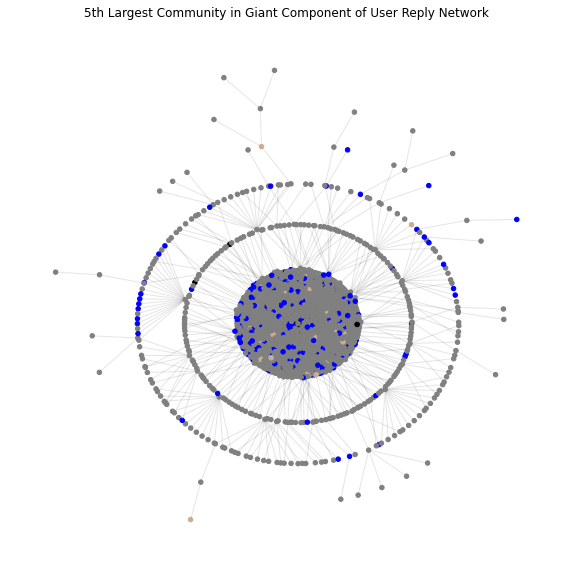

In [97]:
# Choose n, representing the nth largest community in the User network GC
n = 5

nth_comm = pd.Series(gc_partition).value_counts().sort_values(ascending=False).index[n-1]
comm_nodes = [node for node, comm in dict(gc_partition).items() if comm==nth_comm]

user_GC_subgraph = user_GC.subgraph(comm_nodes).copy()

users_giant_comp_list = list(user_GC_subgraph.nodes())
users_final_list = list(users_final_color_dict)
users_node_colors = []

for i in users_giant_comp_list:
    if i not in users_final_list:
        users_node_colors.append('gray')
    else:
        users_node_colors.append(users_final_color_dict[i])


N = user_GC_subgraph.order()
L = user_GC_subgraph.size() 

print(f'{n}th Largest Community of Giant Component:')
print ('Nodes: ', N)
print ('Edges: ', L)
print('Is Network Connected?', nx.is_connected(user_GC_subgraph))

clustering = [c for c in nx.clustering(user_GC_subgraph).values()]

c_min = np.min(clustering)
c_max = np.max(clustering);
c_avg = nx.average_clustering(user_GC_subgraph)

print()
print ('Minimum clustering: ', c_min)
print ('Maximum clustering: ', c_max)
print ('Average clustering: ', c_avg)

s_clusters = pd.Series(clustering)

fig, ax = plt.subplots()
s_clusters.plot(kind='hist', ax=ax)
ax.set_xlim(0, 1)
ax.set_xlabel('Clustering')
ax.set_ylabel('Frequency (log)')
plt.yscale('log')
plt.title('Clustering Distribution')
plt.show()

D = nx.average_shortest_path_length(user_GC_subgraph)
D_max = np.max([list(i.values())
                for i in dict(nx.shortest_path_length(user_GC_subgraph)).values()])

print()
print ('Average Distance: ', D)
print ('Diameter: ', D_max)

pos = nx.kamada_kawai_layout(user_GC_subgraph)
# pos = nx.spring_layout(user_GC_subgraph)
# pos = nx.fruchterman_reingold_layout(user_GC_subgraph)
# pos = nx.circular_layout(user_GC_subgraph)

plt.figure(figsize=(10, 10))

plt.axis("off")
nx.draw_networkx_nodes(user_GC_subgraph, pos, node_size=20, node_color=users_node_colors)
nx.draw_networkx_edges(user_GC_subgraph, pos, alpha=0.10)
plt.title(f'{n}th Largest Community in Giant Component of User Reply Network')
plt.show()

In [73]:
print('Largest communities:')
pd.Series(gc_partition).value_counts().sort_values(ascending=False).iloc[:20]

Largest communities:


0     4403
3     2451
9     1873
15    1590
5     1508
20    1487
2     1115
1     1066
6     1045
16    1007
26     921
14     879
43     796
13     725
18     707
33     639
52     614
30     566
28     548
4      492
dtype: int64

### Centrality

In [74]:
df_user_centrality = pd.DataFrame()
df_user_centrality['degree'] = pd.Series(nx.degree_centrality(user_DG))
df_user_centrality['in_degree'] = pd.Series(nx.in_degree_centrality(user_DG))
df_user_centrality['out_degree'] = pd.Series(nx.out_degree_centrality(user_DG))
df_user_centrality['eigenvector'] = pd.Series(nx.eigenvector_centrality(user_DG, weight='num_replies'))

# This takes a long time to compute:
# df_user_centrality['betweenness'] = pd.Series(nx.betweenness_centrality(user_DG, weight='distance'))
# df_user_centrality['closeness'] = pd.Series(nx.closeness_centrality(user_DG, distance='distance'))

df_user_centrality

degree  in_degree  out_degree   eigenvector
1426227152589139968  0.000000   0.000000    0.000000  1.845587e-13
1076943230657269760  0.000000   0.000000    0.000000  1.845587e-13
1186436773104238592  0.000108   0.000020    0.000088  3.994289e-04
499815801            0.000634   0.000084    0.000550  4.776465e-03
1208864446497591296  0.000074   0.000010    0.000064  7.276792e-04
...                       ...        ...         ...           ...
1343269647756492800  0.000005   0.000000    0.000005  1.845587e-13
1133200868           0.000005   0.000000    0.000005  1.845587e-13
230833678            0.000005   0.000000    0.000005  1.845587e-13
2720077414           0.000005   0.000005    0.000000  1.476470e-12
1492510921704415232  0.000005   0.000005    0.000000  1.476470e-12

[203498 rows x 4 columns]

## Tweet Hashtag Network 

### Building the Network

In [98]:
tweet_hashtags = df_tweets['entities.hashtags'].str.findall(r"'text': '(\w+)'")
all_hashtags = tweet_hashtags[tweet_hashtags.apply(len) > 0]

# Use this line to get the first hashtag only
# all_hashtags = tweet_hashtags.apply(lambda x: x[0])

# Use this line to get all the hashtags
all_hashtags = tweet_hashtags.explode()

print('Unique hashtags:', len(all_hashtags.value_counts()))

Unique hashtags: 25312


In [99]:
# df_tweets['hashtags'] = tweet_hashtags

In [100]:
# pd.set_option('display.max_colwidth', None)
# df_hashtags = df_tweets[['full_text', 'hashtags']]
# pro_Amber = df_hashtags[df_hashtags['hashtags'].apply(lambda x: 'IStandWithAmberHeard' in x)]
# pro_Amber.iloc[:30]

In [101]:
top_hashtag_num = 30
top_hashtags = all_hashtags.value_counts().iloc[:top_hashtag_num].index.to_list()

all_hashtags.value_counts().iloc[:top_hashtag_num]

JusticeForJohnnyDepp                220416
JohnnyDepp                           39558
AmberHeardIsALiar                    31226
AmberHeardIsAnAbuser                 29406
JusticeForJohnnyDeppVirginia2022     24562
AmberHeard                           13867
JohnnyDeppIsInnocent                 13413
JusticeforJohnnyDepp                  9334
IStandWithJohnnyDepp                  8703
JohnnyDeppVsAmberHeard                8695
AmberTurd                             8256
justiceforjohnnydepp                  6598
JohnnyDeppDeservesJustice             5998
JusticeForJohhnyDepp                  5231
Minamata                              3786
AquamanAndTheLostKingdom              3216
MenToo                                3196
MePoo                                 3170
JusticeForJohnnyDeep                  2719
johnnydepp                            2600
AbuseHasNoGender                      2404
OscarsFanFavorite                     2213
DeppVsHeard                           2011
Sweepstakes

In [102]:
# Include only top hashtags

hashtag_G = nx.Graph()

for hashtags in tweet_hashtags:
    if len(hashtags) > 1:
        edges = combinations(hashtags, 2)
        for edge in edges:
            if edge[0] in top_hashtags or edge[1] in top_hashtags:
                if not hashtag_G.has_edge(edge[0], edge[1]):
                    hashtag_G.add_edge(edge[0], edge[1], weight=0)
                else:
                    hashtag_G[edge[0]][edge[1]]['weight'] = hashtag_G[edge[0]][edge[1]]['weight'] + 1

nx.set_node_attributes(hashtag_G, dict(all_hashtags.value_counts()), name="frequency")

hashtag_G.remove_edges_from(nx.selfloop_edges(hashtag_G))
    
print('Nodes:', len(hashtag_G.nodes()))
print('Edges:', len(hashtag_G.edges()))

Nodes: 20689
Edges: 55106


In [103]:
# Include all hashtags

hashtag_all_G = nx.Graph()

for hashtags in tweet_hashtags:
    if len(hashtags) == 1:
        hashtag_all_G.add_node(hashtags[0])
    elif len(hashtags) > 1:
        edges = combinations(hashtags, 2)
        for edge in edges:
            if not hashtag_all_G.has_edge(edge[0], edge[1]):
                hashtag_all_G.add_edge(edge[0], edge[1], weight=0)
            else:
                hashtag_all_G[edge[0]][edge[1]]['weight'] = hashtag_all_G[edge[0]][edge[1]]['weight'] + 1

nx.set_node_attributes(hashtag_all_G, dict(all_hashtags.value_counts()), name="frequency")
                
hashtag_all_G.remove_edges_from(nx.selfloop_edges(hashtag_G))
    
print('Nodes:', len(hashtag_all_G.nodes()))
print('Edges:', len(hashtag_all_G.edges()))

Nodes: 25312
Edges: 145999


### Degree Distribution

In [104]:
tweet_hashtag_degrees = pd.DataFrame(hashtag_G.degree())
tweet_hashtag_degrees.columns = ['node', 'degree']
tweet_hashtag_degrees = tweet_hashtag_degrees.set_index('node')['degree']
tweet_hashtag_degrees.sort_values(ascending=False).iloc[:30]

node
JusticeForJohnnyDepp                15807
JohnnyDepp                           5850
AmberHeardIsALiar                    4398
AmberHeardIsAnAbuser                 3964
AmberHeard                           3649
JusticeForJohnnyDeppVirginia2022     2594
JohnnyDeppIsInnocent                 1959
AmberTurd                            1813
JohnnyDeppVsAmberHeard               1616
justiceforjohnnydepp                 1201
johnnydepp                           1201
JohnnyDeppDeservesJustice            1201
IStandWithJohnnyDepp                 1169
JusticeforJohnnyDepp                  990
JusticeForJohhnyDepp                  915
MenToo                                872
AbuseHasNoGender                      842
MePoo                                 826
AquamanAndTheLostKingdom              778
JohnnyDepptrial                       583
JusticeForJohnnyDeep                  547
DeppVsHeard                           511
NeverFearTruth                        500
AmberHeardDeservesPrison     

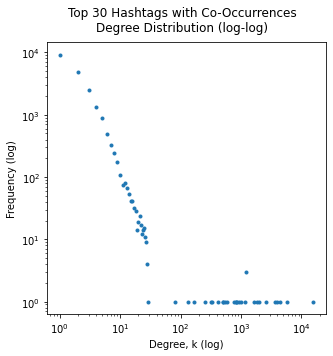

In [105]:
# Top hashtags only

fix, ax = plt.subplots(figsize=(5, 5))
plt.loglog(nx.degree_histogram(hashtag_G), '.')
plt.xlabel("Degree, k (log)")
plt.ylabel("Frequency (log)")
plt.suptitle('Top 30 Hashtags with Co-Occurrences\nDegree Distribution (log-log)')
plt.show()

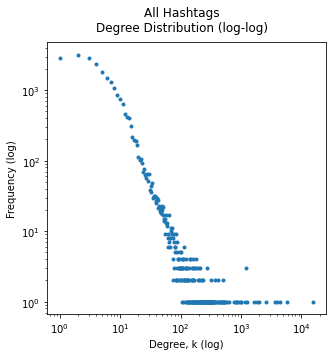

In [106]:
# All hashtags

fix, ax = plt.subplots(figsize=(5, 5))
plt.loglog(nx.degree_histogram(hashtag_all_G), '.')
plt.xlabel("Degree, k (log)")
plt.ylabel("Frequency (log)")
plt.suptitle('All Hashtags\nDegree Distribution (log-log)')
plt.show()

### Other Network Stats

#### Of Original Network

Original Network (Complete):
Nodes:  20689
Edges:  55106
Is Network Connected? True

Minimum clustering:  0.0
Maximum clustering:  1.0
Average clustering:  0.5513978894369957


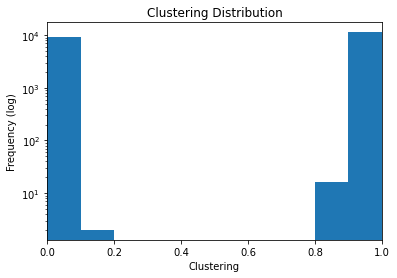

Notes:
Cannot get distances of an unconnected network.
Network is too big to plot.


In [107]:
N = hashtag_G.order()
L = hashtag_G.size() 

print('Original Network (Complete):')
print ('Nodes: ', N)
print ('Edges: ', L)
print('Is Network Connected?', nx.is_connected(hashtag_G))

clustering = [c for c in nx.clustering(hashtag_G).values()]

c_min = np.min(clustering)
c_max = np.max(clustering);
c_avg = nx.average_clustering(hashtag_G)

print()
print ('Minimum clustering: ', c_min)
print ('Maximum clustering: ', c_max)
print ('Average clustering: ', c_avg)

s_clusters = pd.Series(clustering)

fig, ax = plt.subplots()
s_clusters.plot(kind='hist', ax=ax)
ax.set_xlim(0, 1)
ax.set_xlabel('Clustering')
ax.set_ylabel('Frequency (log)')
plt.yscale('log')
plt.title('Clustering Distribution')
plt.show()

print('Notes:')
print('Cannot get distances of an unconnected network.')
print('Network is too big to plot.')

#### Of Giant Component

In [108]:
hashtag_GC_nodes = max(nx.connected_components(hashtag_G), key=len)
hashtag_GC = hashtag_G.subgraph(hashtag_GC_nodes).copy()

N = hashtag_GC.order()
L = hashtag_GC.size() 

print('Giant Component (Undirected):')
print ('Nodes: ', N)
print ('Edges: ', L)
print('Is Network Connected?', nx.is_connected(hashtag_GC))

# clustering = [c for c in nx.clustering(hashtag_GC).values()]

# c_min = np.min(clustering)
# c_max = np.max(clustering);
# c_avg = nx.average_clustering(hashtag_GC)

# print()
# print ('Minimum clustering: ', c_min)
# print ('Maximum clustering: ', c_max)
# print ('Average clustering: ', c_avg)

# s_clusters = pd.Series(clustering)

# fig, ax = plt.subplots()
# s_clusters.plot(kind='hist', ax=ax)
# ax.set_xlim(0, 1)
# ax.set_xlabel('Clustering')
# ax.set_ylabel('Frequency (log)')
# plt.yscale('log')
# plt.title('Clustering Distribution')
# plt.show()

# # D = nx.average_shortest_path_length(hashtag_GC)
# # D_max = np.max([list(i.values())
# #                 for i in dict(nx.shortest_path_length(hashtag_GC)).values()])

# # print()
# # print ('Average Distance: ', D)
# # print ('Diameter: ', D_max)

# # pos = nx.kamada_kawai_layout(hashtag_GC)
# # # pos = nx.spring_layout(hashtag_GC)
# # # pos = nx.fruchterman_reingold_layout(hashtag_GC)
# # # pos = nx.circular_layout(hashtag_GC)

# # plt.figure(figsize=(8, 8))

# # plt.axis("off")
# # nx.draw_networkx_nodes(hashtag_GC, pos, node_size=20, node_color='tab:blue')
# # nx.draw_networkx_edges(hashtag_GC, pos, alpha=0.10)
# # plt.title(f'Giant Component of Tweet Hashtag Network')
# # plt.show()

# print('Notes:')
# print('Network is too big to plot or obtain distances.')

Giant Component (Undirected):
Nodes:  20689
Edges:  55106
Is Network Connected? True


### Components

Number of components: 1
Mean component size: 20689.0
Max component size: 20689


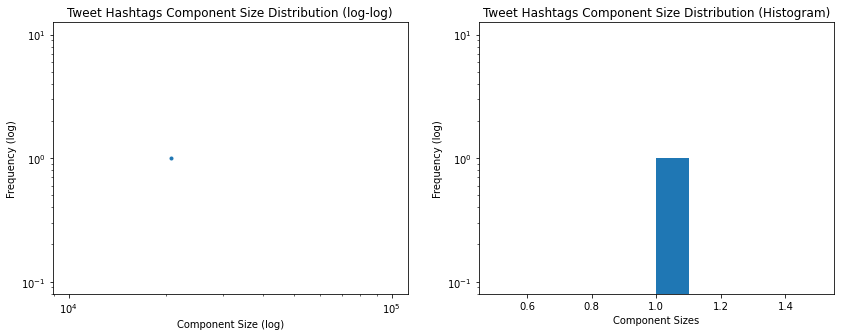

In [109]:
all_component_sizes = pd.Series([len(component) for component in (nx.connected_components(hashtag_G))])

component_sizes = all_component_sizes.value_counts().index
component_size_freqs = all_component_sizes.value_counts(ascending=False).values

print('Number of components:', len(all_component_sizes))

# Comment these out if just getting the top n hashtags
# print('Number of components with just 1 node):', all_component_sizes.value_counts()[1])
# print('Number of components with replies (2 nodes or more):',
#       len(all_component_sizes) - all_component_sizes.value_counts()[1])

print('Mean component size:', np.mean(all_component_sizes))
print('Max component size:', np.max(all_component_sizes))

fix, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(component_sizes, component_size_freqs, marker='.')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("Component Size (log)")
ax[0].set_ylabel("Frequency (log)")
ax[0].set_title('Tweet Hashtags Component Size Distribution (log-log)')

ax[1].hist(all_component_sizes.value_counts().to_numpy())
ax[1].set_yscale('log')
ax[1].set_xlabel("Component Sizes")
ax[1].set_ylabel("Frequency (log)")
ax[1].set_title('Tweet Hashtags Component Size Distribution (Histogram)')
plt.show()

In [110]:
all_component_sizes.sort_values(ascending=False)

0    20689
dtype: int64

### Cores

In [111]:
pd.Series(nx.core_number(hashtag_G)).value_counts().sort_index()

1     9245
2     4859
3     2471
4     1311
5      873
6      489
7      331
8      241
9      174
10     108
11      75
12      79
13      66
14      53
15      42
16      41
17      32
18      29
19      14
20      20
21      25
22      18
23      13
24      14
25      18
26      14
27      34
dtype: int64

In [112]:
print('0-core (original complete network):')
hashtag_0core = nx.k_core(hashtag_G, k=0)
print('Nodes:', len(hashtag_0core.nodes()))
print('Edges:', len(hashtag_0core.edges()))
print('Is Network Connected ?',
      nx.is_connected(hashtag_0core.to_undirected()))

print()
print('1-core (original reply network):')
hashtag_1core = nx.k_core(hashtag_G, k=1)
print('Nodes:', len(hashtag_1core.nodes()))
print('Edges:', len(hashtag_1core.edges()))
print('Is Network Connected?',
      nx.is_connected(hashtag_1core))

print()
print('2-core:')
hashtag_2core = nx.k_core(hashtag_G, k=2)
print('Nodes:', len(hashtag_2core.nodes()))
print('Edges:', len(hashtag_2core.edges()))
print('Is Network Connected?',
      nx.is_connected(hashtag_2core))

for i in range(10, pd.Series(nx.core_number(hashtag_G)).max(), 10):
    print()
    print(f'{i}-core')
    hashtag_kcore = nx.k_core(hashtag_G, k=i)
    print('Nodes:', len(hashtag_kcore.nodes()))
    print('Edges:', len(hashtag_kcore.edges()))
    print('Is Network Connected?',
          nx.is_connected(hashtag_kcore))
    
hashtag_kcore = nx.k_core(hashtag_G)
k_max = pd.Series(nx.core_number(hashtag_kcore)).max()
print()
print(f'{k_max}-core (main core)')
print('Nodes:', len(hashtag_kcore.nodes()))
print('Edges:', len(hashtag_kcore.edges()))
print('Is Network Connected (if undirected)?',
      nx.is_connected(hashtag_kcore))

0-core (original complete network):
Nodes: 20689
Edges: 55106
Is Network Connected ? True

1-core (original reply network):
Nodes: 20689
Edges: 55106
Is Network Connected? True

2-core:
Nodes: 11444
Edges: 45861
Is Network Connected? True

10-core
Nodes: 695
Edges: 10376
Is Network Connected? True

20-core
Nodes: 156
Edges: 3305
Is Network Connected? True

27-core (main core)
Nodes: 34
Edges: 537
Is Network Connected (if undirected)? True


27-core (max core)
Nodes: 34
Edges: 537


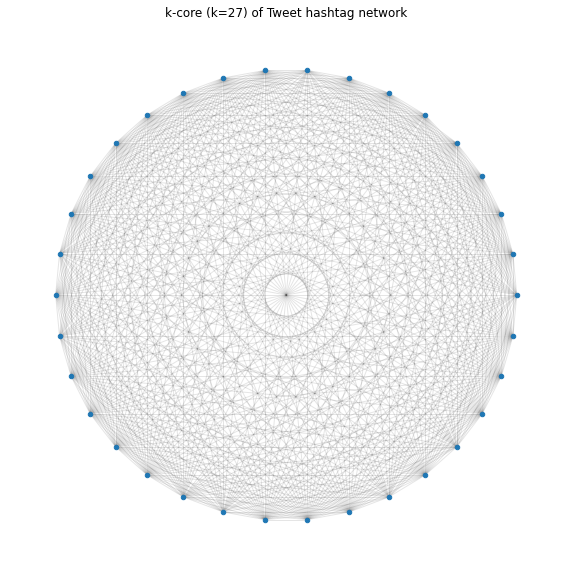

In [113]:
k = pd.Series(nx.core_number(hashtag_G)).max()

hashtag_kcore = nx.k_core(hashtag_G, k=k)
print(f'{k}-core (max core)')
print('Nodes:', len(hashtag_kcore.nodes()))
print('Edges:', len(hashtag_kcore.edges()))

pos = nx.kamada_kawai_layout(hashtag_kcore)
# pos = nx.spring_layout(hashtag_kcore)
# pos = nx.fruchterman_reingold_layout(hashtag_kcore)
# pos = nx.circular_layout(hashtag_kcore)

plt.figure(figsize=(10, 10))

plt.axis("off")
nx.draw_networkx_nodes(hashtag_kcore, pos, node_size=20, node_color='tab:blue')
nx.draw_networkx_edges(hashtag_kcore, pos, alpha=0.10)
# nx.draw_networkx_labels(user_kcore, pos, font_color="black", font_size=11)
plt.title(f'k-core (k={k}) of Tweet hashtag network')
plt.show()

### Communities and Community Size Distribution

#### From Giant Component

In [114]:
gc_partition = community.best_partition(hashtag_GC, weight='weight',
                                        randomize=False, random_state=0)

print(f'Giant Component')
print('Nodes:', len(hashtag_GC.nodes()))
print('Edges:', len(hashtag_GC.edges()))
print('Is Network Connected?', nx.is_connected(hashtag_GC))
print('\nNumber of communities:', len(set(gc_partition.values())))
print('Modularity:', community.modularity(gc_partition, hashtag_GC, weight='weight'))

# # GC is too big to plot

# # pos = nx.kamada_kawai_layout(user_GC)
# pos = nx.fruchterman_reingold_layout(user_GC)
# # pos = nx.spring_layout(user_GC)
# # pos = nx.circular_layout(user_GC)

# plt.figure(figsize=(12,12));
# plt.axis("off");
# nx.draw_networkx_nodes(user_GC, pos, node_size=50, cmap='Accent',
#                        node_color=list(kcore_partition.values()))
# nx.draw_networkx_edges(user_GC, pos, alpha=0.10)
# # nx.draw_networkx_labels(user_GC, pos, labels=partition,
# #                         font_color="white", font_size=8)
# plt.show()

Giant Component
Nodes: 20689
Edges: 55106
Is Network Connected? True

Number of communities: 14836
Modularity: 0.11861427411677676


In [115]:
top_communities = pd.Series(gc_partition).value_counts()
top_communities.iloc[:20]

0       4271
2        942
5        288
4        278
10        66
134       14
9894       1
9898       1
9897       1
9896       1
9895       1
9891       1
9893       1
9892       1
9900       1
9890       1
9889       1
9888       1
9899       1
9903       1
dtype: int64

In [116]:
print('Number of communities:', len(top_communities))
print('Communities with more than one node:', 6)
print('Communities with only one node:', len(top_communities)-6)

Number of communities: 14836
Communities with more than one node: 6
Communities with only one node: 14830


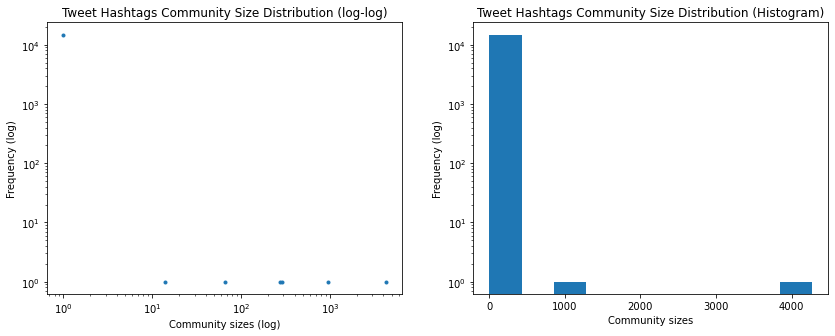

In [118]:
community_size_array = pd.Series(gc_partition).value_counts().values
community_size_value_counts = pd.Series(community_size_array).value_counts()

community_sizes = community_size_value_counts.index
community_size_freqs = community_size_value_counts.values

fix, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].scatter(community_sizes, community_size_freqs, marker='.')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("Community sizes (log)")
ax[0].set_ylabel("Frequency (log)")
ax[0].set_title('Tweet Hashtags Community Size Distribution (log-log)')

ax[1].hist(pd.Series(gc_partition).value_counts().to_numpy())
ax[1].set_yscale('log')
ax[1].set_xlabel("Community sizes")
ax[1].set_ylabel("Frequency (log)")
ax[1].set_title('Tweet Hashtags Community Size Distribution (Histogram)')
plt.show()

In [120]:
top_communities.iloc[:7]

0       4271
2        942
5        288
4        278
10        66
134       14
9894       1
dtype: int64

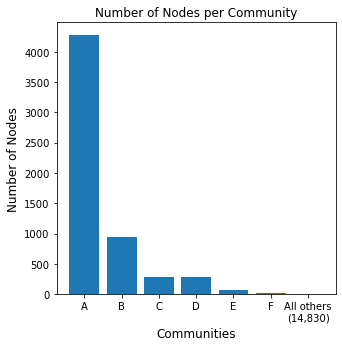

In [121]:
community_plot = top_communities.iloc[:7]
community_plot.index = ['A', 'B', 'C', 'D', 'E', 'F', 'All others\n(14,830)']

fix, ax = plt.subplots(figsize=(5, 5))

ax.bar(x=community_plot.index, height=list(community_plot))
ax.set_xlabel("Communities", fontsize=12)
ax.set_ylabel("Number of Nodes", fontsize=12)
ax.set_title('Number of Nodes per Community', fontsize=12)
plt.show()

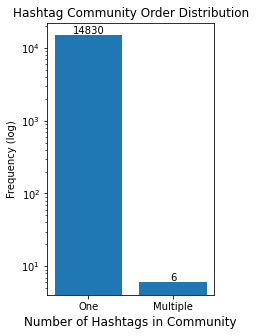

In [122]:
sizes = [len(top_communities) - len(top_communities[top_communities > 1]),
         len(top_communities[top_communities > 1])]


fix, ax = plt.subplots(figsize=(3, 5))

ax.bar(x=['One', 'Multiple'], height=sizes)
ax.set_yscale('log')
ax.set_ylabel("Frequency (log)")
ax.set_xlabel("Number of Hashtags in Community", fontsize=12)
ax.set_title('Hashtag Community Order Distribution')

rects = ax.patches

# Make some labels.
labels = sizes

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height,
            label, ha="center", va="bottom")

plt.show()

#### From select communities

In [123]:
hashtag_communities = pd.Series(dict(gc_partition))

comm_list = [0, 2, 5, 4, 10, 134]
# comm_list = top_communities.index[:5]

for comm in comm_list:
    print('Community:', comm)
    display(hashtag_communities[hashtag_communities==comm].iloc[:20].index.to_list())

Community: 0


['BoycottWarnerBrothers',
 'JusticeForJohnnyDepp',
 'BoycottFantasticBeasts3',
 'AmandaHeard',
 'AmberHeardIsTheRealAbuser',
 'JusticeForJohnnyDeppVirginia2022',
 'JohnnyDepp',
 'AmberHeard',
 'BoycottWB',
 'PaulBettany',
 'sundayvibes',
 'HappyNewYear',
 'PeaceAndLove',
 'JohnnyDeppLOVEforever',
 'WeStandWithJohnnyDepp',
 'TeamDepp',
 'Boycottaquaman2',
 'Virginia2022',
 'JusticeForAllSurvivors',
 'JohnnyDeppIsMyGrindelwald']

Community: 2


['amberheardperjury',
 'AbuseHasNoGender',
 'SpreadTheWord',
 'AmberHeardIsAnAbuser',
 'AmberHeardIsALiar',
 'MenToo',
 'AmberHeardIsADangerToOthers',
 'AmberHeardIsAProvenLiar',
 'karma',
 'AmberHeardDeservesPrison',
 'Aquaman',
 'GrowUp',
 'AmberHeardDidNotDonate',
 'AmberHeardIsAGoldDigger',
 'BoycottAquaman2',
 'Aquaman2',
 'EveFartlow',
 'AmberHeardIsAGolddigger',
 'getsaroundabit',
 'Liar']

Community: 5


['JohnnyDeppIsInnocent',
 'JohnnyDeppisInnocent',
 'IStandWithJohnnyDepp',
 'WeAreYourWarriors',
 'JusticeforJohnnyDepp',
 'IAmADeppWarrior',
 'JohnnyDeppDeservesJustice',
 'LoveProtectSupportJD',
 'NoJohnnyNoMoney',
 'ISupportJohnnyDepp',
 'IStandWithPaulBettany',
 'WebelieveJohnny',
 'IstandwithJohnnyDepp',
 'IBelieveJohnnyDepp',
 'JohnnyDeppIsASurvivor',
 'YouCantKeepAGoodManDown',
 'PositivityforJohnnyDepp',
 'JusticeforJohnnyDeppVirginia2022',
 'Abusehasnogender',
 'DomesticAbuse']

Community: 4


['johnnydepp',
 'johnnydeppisinnocent',
 'depphead',
 'justiceforjohnnydepp',
 'ДжонниДепп',
 'SundayThoughts',
 'amberheardisaliar',
 'amberheardisanabuser',
 'defamation',
 'justiceforjohnnydeppvirginia2022',
 'teamjohnnydepp',
 'abusehasnogender',
 'teamjohnny',
 'istandwithjohnnydepp',
 'boycottFantasticBeasts3',
 'fanart',
 'Amberheardisabuser',
 'johnnydeppedit',
 'johnnydeppvideos',
 'justiceForJohnnyDepp']

Community: 10


['StopTheShock',
 'MinamataFilm',
 'Minamata',
 'JusticeForMinamata',
 'TheAcademy',
 'minamata',
 'minamatafilm',
 'Oscars',
 'love',
 'Oscar',
 'ThePowerOfTheSmall',
 'Feburary12',
 'OscarsFanFavorite',
 'Sweepstakes',
 'OscarNoms',
 'MinamataMovie',
 'MinamataWatchParty',
 'OscarsFanFavourite',
 'EugeneSmith',
 'AcademyAwards']

Community: 134


['JohnnyDeppisawifebeater',
 'HappyBirthdayAmberHeard',
 'IStandWithAmberHeard',
 'misogyny',
 'JUSTICEFORAMBERHEARD',
 'JohnnyDeppIsAnAbuser',
 'JohnnyDeppisarapist',
 'freeamberheard',
 'MentalHealthAwarenessMonth',
 'justiceforamberheard',
 'FuckJohnnyDepp',
 'JohnnyDeppIsAWifeBeater',
 'Icon',
 'JohnnyDeppisanabuser']

5 of the Largest Communities in the Giant Component:
Nodes:  4271
Edges:  9757
Is Network Connected? True

Minimum clustering:  0.0
Maximum clustering:  1.0
Average clustering:  0.6305636462034966


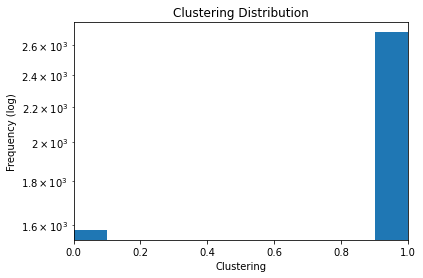


Average Distance:  2.061002447199867
Diameter:  3


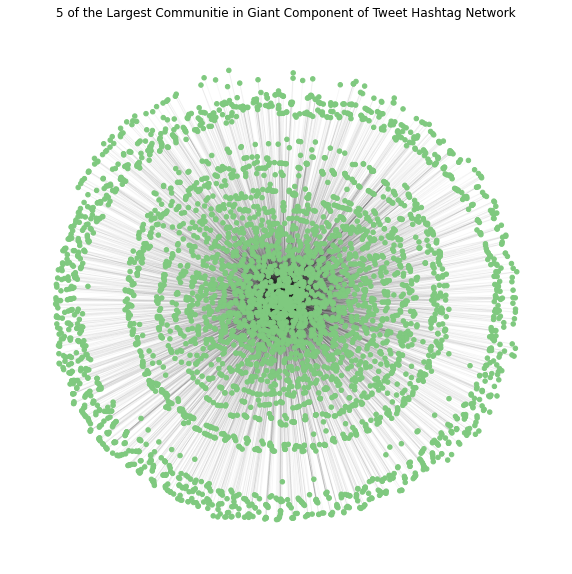

In [124]:
# Choose communities to plot

comm_list = [0]
# comm_list = top_communities.index[1:6]
comm_nodes = [node for node, comm in dict(gc_partition).items() if comm in comm_list]

hashtag_GC_subgraph = hashtag_GC.subgraph(comm_nodes).copy()

# Use this if getting all hashtags as nodes
# node_colors = [comm for node, comm in dict(gc_partition).items() if comm in comm_list]

# Use this if getting top hashtags and co-occurrences as nodes:
comm_dict = dict(gc_partition)
color_map = {0:0, 2:0, 5:1, 4:2, 10:3, 134:4}
node_colors = [comm_dict[node] for node in hashtag_GC_subgraph.nodes()]
node_colors = pd.Series(node_colors).map(color_map).to_list()

N = hashtag_GC_subgraph.order()
L = hashtag_GC_subgraph.size() 

print(f'5 of the Largest Communities in the Giant Component:')
print ('Nodes: ', N)
print ('Edges: ', L)
print('Is Network Connected?', nx.is_connected(hashtag_GC_subgraph))

clustering = [c for c in nx.clustering(hashtag_GC_subgraph).values()]

c_min = np.min(clustering)
c_max = np.max(clustering);
c_avg = nx.average_clustering(hashtag_GC_subgraph)

print()
print ('Minimum clustering: ', c_min)
print ('Maximum clustering: ', c_max)
print ('Average clustering: ', c_avg)

s_clusters = pd.Series(clustering)

fig, ax = plt.subplots()
s_clusters.plot(kind='hist', ax=ax)
ax.set_xlim(0, 1)
ax.set_xlabel('Clustering')
ax.set_ylabel('Frequency (log)')
plt.yscale('log')
plt.title('Clustering Distribution')
plt.show()

D = nx.average_shortest_path_length(hashtag_GC_subgraph)
D_max = np.max([list(i.values())
                for i in dict(nx.shortest_path_length(hashtag_GC_subgraph)).values()])

print()
print ('Average Distance: ', D)
print ('Diameter: ', D_max)

# pos = nx.kamada_kawai_layout(hashtag_GC_subgraph)
# pos = nx.spring_layout(hashtag_GC_subgraph)
pos = nx.fruchterman_reingold_layout(hashtag_GC_subgraph)
# pos = nx.circular_layout(hashtag_GC_subgraph)

plt.figure(figsize=(10, 10))

plt.axis("off")
nx.draw_networkx_nodes(hashtag_GC_subgraph, pos, node_size=20,
                       cmap='Accent', node_color=node_colors)
nx.draw_networkx_edges(hashtag_GC_subgraph, pos, alpha=0.03)
plt.title(f'5 of the Largest Communitie in Giant Component of Tweet Hashtag Network')
plt.show()

5 of the Largest Communities in the Giant Component:
Nodes:  1588
Edges:  7246
Is Network Connected? True

Minimum clustering:  0.0
Maximum clustering:  1.0
Average clustering:  0.8124485756659502


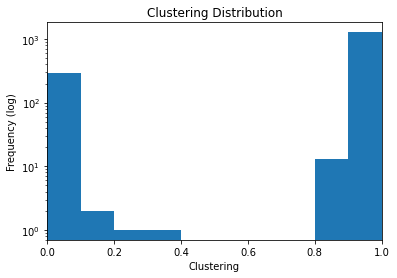


Average Distance:  2.323072063792876
Diameter:  4


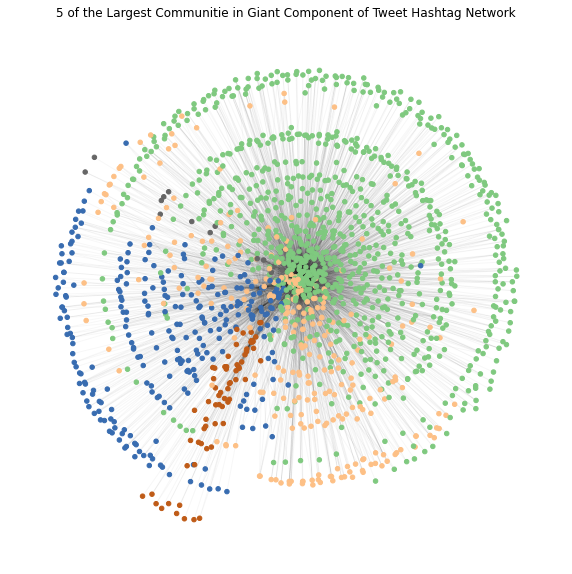

In [125]:
# Choose communities to plot

comm_list = [2, 5, 4, 10, 134]
# comm_list = top_communities.index[1:6]
comm_nodes = [node for node, comm in dict(gc_partition).items() if comm in comm_list]

hashtag_GC_subgraph = hashtag_GC.subgraph(comm_nodes).copy()

# Use this if getting all hashtags as nodes
# node_colors = [comm for node, comm in dict(gc_partition).items() if comm in comm_list]

# Use this if getting top hashtags and co-occurrences as nodes:
comm_dict = dict(gc_partition)
color_map = {2:0, 5:1, 4:2, 10:3, 134:4}
node_colors = [comm_dict[node] for node in hashtag_GC_subgraph.nodes()]
node_colors = pd.Series(node_colors).map(color_map).to_list()

N = hashtag_GC_subgraph.order()
L = hashtag_GC_subgraph.size() 

print(f'5 of the Largest Communities in the Giant Component:')
print ('Nodes: ', N)
print ('Edges: ', L)
print('Is Network Connected?', nx.is_connected(hashtag_GC_subgraph))

clustering = [c for c in nx.clustering(hashtag_GC_subgraph).values()]

c_min = np.min(clustering)
c_max = np.max(clustering);
c_avg = nx.average_clustering(hashtag_GC_subgraph)

print()
print ('Minimum clustering: ', c_min)
print ('Maximum clustering: ', c_max)
print ('Average clustering: ', c_avg)

s_clusters = pd.Series(clustering)

fig, ax = plt.subplots()
s_clusters.plot(kind='hist', ax=ax)
ax.set_xlim(0, 1)
ax.set_xlabel('Clustering')
ax.set_ylabel('Frequency (log)')
plt.yscale('log')
plt.title('Clustering Distribution')
plt.show()

D = nx.average_shortest_path_length(hashtag_GC_subgraph)
D_max = np.max([list(i.values())
                for i in dict(nx.shortest_path_length(hashtag_GC_subgraph)).values()])

print()
print ('Average Distance: ', D)
print ('Diameter: ', D_max)

# pos = nx.kamada_kawai_layout(hashtag_GC_subgraph)
# pos = nx.spring_layout(hashtag_GC_subgraph)
pos = nx.fruchterman_reingold_layout(hashtag_GC_subgraph)
# pos = nx.circular_layout(hashtag_GC_subgraph)


plt.figure(figsize=(10, 10))

plt.axis("off")
nx.draw_networkx_nodes(hashtag_GC_subgraph, pos, node_size=20,
                       cmap='Accent', node_color=node_colors)
nx.draw_networkx_edges(hashtag_GC_subgraph, pos, alpha=0.03)
plt.title(f'5 of the Largest Communitie in Giant Component of Tweet Hashtag Network')
plt.show()

Hashtag Communities:
Nodes:  5859
Edges:  28273
Is Network Connected? True

Minimum clustering:  0.0
Maximum clustering:  1.0
Average clustering:  0.782471952583165


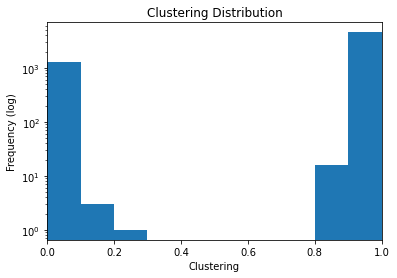

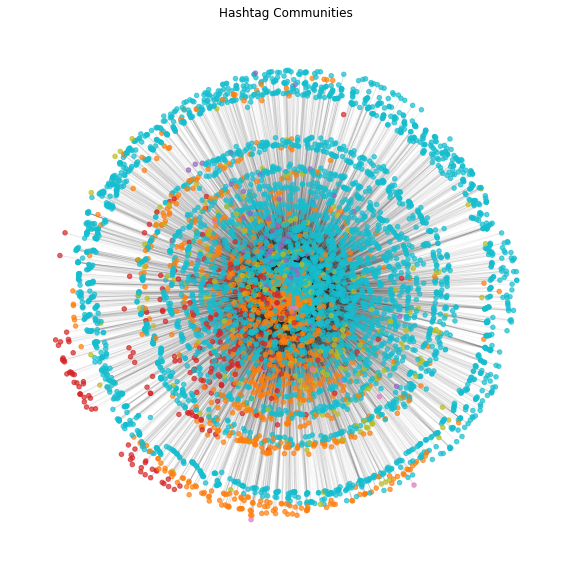

In [126]:
# Choose communities to plot

comm_list = [0, 2, 5, 4, 10, 134]
# comm_list = top_communities.index[1:6]
comm_nodes = [node for node, comm in dict(gc_partition).items() if comm in comm_list]

hashtag_GC_subgraph = hashtag_GC.subgraph(comm_nodes).copy()

# Use this if getting all hashtags as nodes
# node_colors = [comm for node, comm in dict(gc_partition).items() if comm in comm_list]

# Use this if getting top hashtags and co-occurrences as nodes:
comm_dict = dict(gc_partition)
color_map = {0:'tab:cyan', 2:'tab:orange', 5:'tab:olive',
             4:'tab:red', 10:'tab:purple', 134:'tab:pink'}
node_colors = [comm_dict[node] for node in hashtag_GC_subgraph.nodes()]
node_colors = pd.Series(node_colors).map(color_map).to_list()

N = hashtag_GC_subgraph.order()
L = hashtag_GC_subgraph.size() 

print(f'Hashtag Communities:')
print ('Nodes: ', N)
print ('Edges: ', L)
print('Is Network Connected?', nx.is_connected(hashtag_GC_subgraph))

clustering = [c for c in nx.clustering(hashtag_GC_subgraph).values()]

c_min = np.min(clustering)
c_max = np.max(clustering);
c_avg = nx.average_clustering(hashtag_GC_subgraph)

print()
print ('Minimum clustering: ', c_min)
print ('Maximum clustering: ', c_max)
print ('Average clustering: ', c_avg)

s_clusters = pd.Series(clustering)

fig, ax = plt.subplots()
s_clusters.plot(kind='hist', ax=ax)
ax.set_xlim(0, 1)
ax.set_xlabel('Clustering')
ax.set_ylabel('Frequency (log)')
plt.yscale('log')
plt.title('Clustering Distribution')
plt.show()

# D = nx.average_shortest_path_length(hashtag_GC_subgraph)
# D_max = np.max([list(i.values())
#                 for i in dict(nx.shortest_path_length(hashtag_GC_subgraph)).values()])

# print()
# print ('Average Distance: ', D)
# print ('Diameter: ', D_max)

# pos = nx.kamada_kawai_layout(hashtag_GC_subgraph)
# pos = nx.spring_layout(hashtag_GC_subgraph)
pos = nx.fruchterman_reingold_layout(hashtag_GC_subgraph)
# pos = nx.circular_layout(hashtag_GC_subgraph)

plt.figure(figsize=(10, 10))

plt.axis("off")
nx.draw_networkx_nodes(hashtag_GC_subgraph, pos, node_size=20,
                       cmap='tab10', node_color=node_colors, alpha=0.7)
nx.draw_networkx_edges(hashtag_GC_subgraph, pos, alpha=0.03)
plt.title(f'Hashtag Communities')
plt.show()

##### Centrality

In [127]:
df_hashtag_centrality = pd.DataFrame()
df_hashtag_centrality['node'] = [node for node, partition in gc_partition.items()
                                           if node in comm_nodes]
df_hashtag_centrality['partition'] = [partition for node, partition in gc_partition.items()
                                                if node in comm_nodes]
df_hashtag_centrality['frequency'] = [count for node, count in all_hashtags.value_counts().items()
                                                if node in comm_nodes]
df_hashtag_centrality['degree'] = nx.degree_centrality(hashtag_GC_subgraph).values()
df_hashtag_centrality['eigenvector'] = nx.eigenvector_centrality(hashtag_GC_subgraph, weight='weight').values()

df_hashtag_centrality

node  partition  frequency    degree  \
0                 BoycottWarnerBrothers          0     220416  0.000341   
1                  JusticeForJohnnyDepp          0      39558  0.002219   
2               BoycottFantasticBeasts3          0      31226  0.001878   
3                           AmandaHeard          0      29406  0.000341   
4                     amberheardperjury          2      24562  0.000683   
...                                 ...        ...        ...       ...   
5854  justwheniwasdoingsogoodwithouther          0          1  0.000171   
5855                          AMBERLIED          2          1  0.003926   
5856               JusticeFroJohnnyDepp          0          1  0.000171   
5857                     JoyForTheMases          0          1  0.000341   
5858                            ThanYou          0          1  0.000341   

       eigenvector  
0     3.770579e-05  
1     9.976571e-04  
2     1.403047e-04  
3     9.426447e-06  
4     2.827934e-05  
...            ...  
5854  9.426447e-06  
5855  6.504215e-03  
5856  5.796090e-07  
5857  9.900648e-06  
5858  4.731828e-05  

[5859 rows x 5 columns]

In [129]:
for partition in comm_list:
    print()
    print('Community:', partition)
    print(df_hashtag_centrality[df_hashtag_centrality['partition'] == partition].
          sort_values('frequency', ascending=False)['node'].iloc[:30].to_list())


Community: 0
['BoycottWarnerBrothers', 'JusticeForJohnnyDepp', 'BoycottFantasticBeasts3', 'AmandaHeard', 'AmberHeardIsTheRealAbuser', 'JusticeForJohnnyDeppVirginia2022', 'JohnnyDepp', 'AmberHeard', 'BoycottWB', 'PaulBettany', 'sundayvibes', 'HappyNewYear', 'PeaceAndLove', 'JohnnyDeppLOVEforever', 'WeStandWithJohnnyDepp', 'TeamDepp', 'Boycottaquaman2', 'Virginia2022', 'JusticeForAllSurvivors', 'JohnnyDeppIsMyGrindelwald', 'MarilynMansonIsInnocent', 'truth', 'mentoo', 'JamesFranco', 'delusional', 'NoJohnnyNoPirates', 'JohnnyDeppIsASurvivorOfDV', 'Love', 'Respect', 'Truth']

Community: 2
['amberheardperjury', 'AbuseHasNoGender', 'SpreadTheWord', 'AmberHeardIsAnAbuser', 'AmberHeardIsALiar', 'MenToo', 'AmberHeardIsADangerToOthers', 'AmberHeardIsAProvenLiar', 'karma', 'AmberHeardDeservesPrison', 'Aquaman', 'GrowUp', 'AmberHeardDidNotDonate', 'AmberHeardIsAGoldDigger', 'BoycottAquaman2', 'Aquaman2', 'EveFartlow', 'AmberHeardIsAGolddigger', 'getsaroundabit', 'Liar', 'scum', 'AmberHeardPerjury

#### Select Hashtag Communities with Labels

5th Largest Community of Giant Component:
Nodes:  288
Edges:  623
Is Network Connected? True

Minimum clustering:  0.0
Maximum clustering:  1.0
Average clustering:  0.6152815723648444


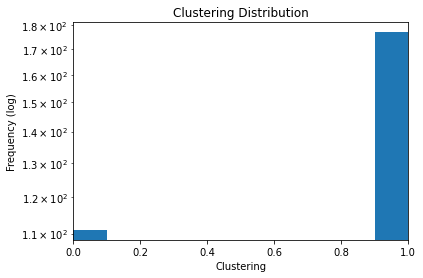


Average Distance:  2.2746322106078205
Diameter:  3


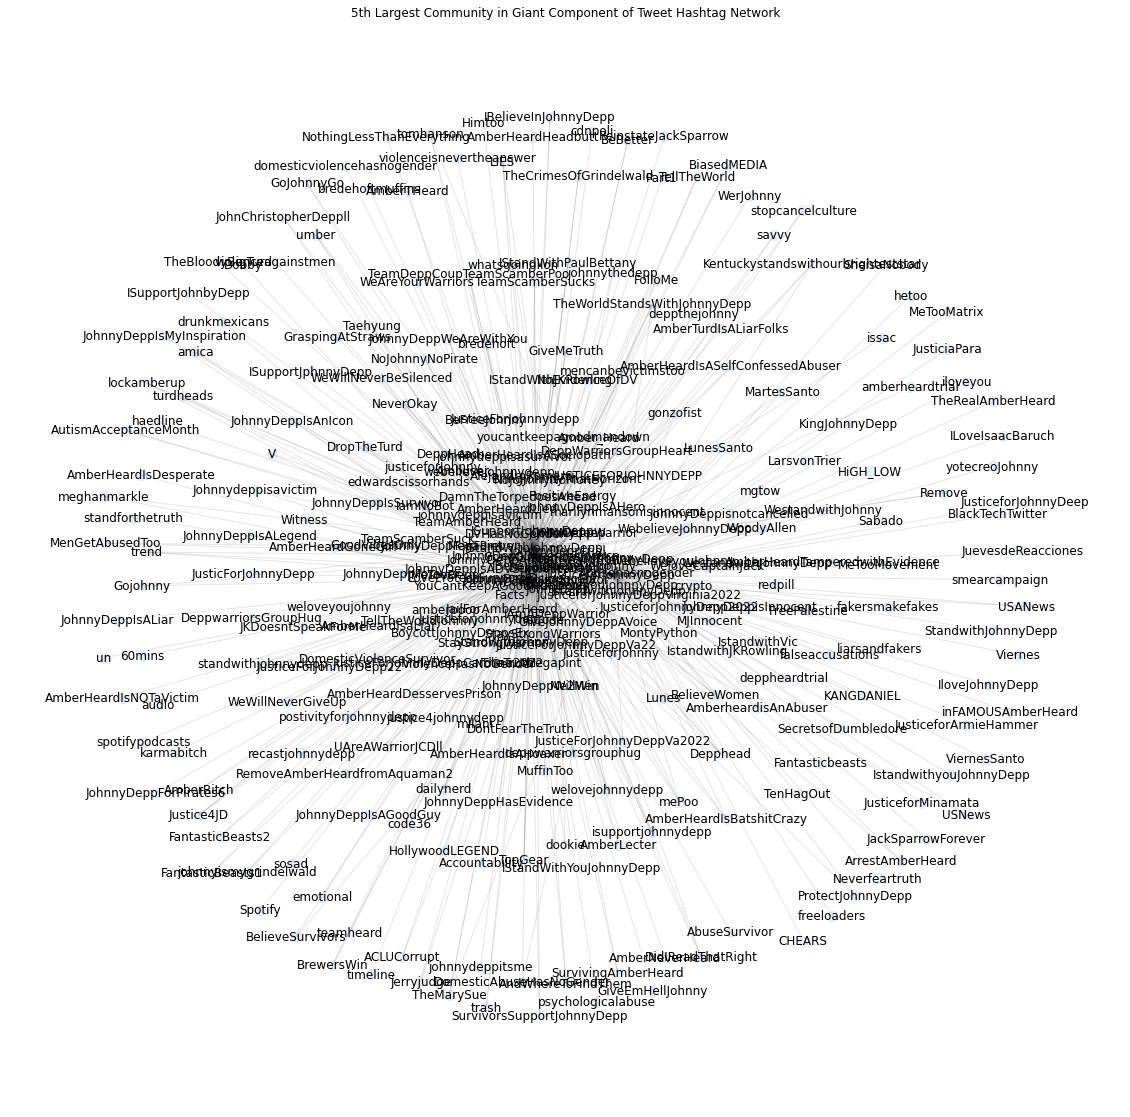

In [130]:
# Choose nth_comm, representing the community to be plotted

nth_comm = 5
comm_nodes = [node for node, comm in dict(gc_partition).items() if comm==nth_comm]

hashtag_GC_subgraph = hashtag_GC.subgraph(comm_nodes).copy()

N = hashtag_GC_subgraph.order()
L = hashtag_GC_subgraph.size() 

print(f'{n}th Largest Community of Giant Component:')
print ('Nodes: ', N)
print ('Edges: ', L)
print('Is Network Connected?', nx.is_connected(hashtag_GC_subgraph))

clustering = [c for c in nx.clustering(hashtag_GC_subgraph).values()]

c_min = np.min(clustering)
c_max = np.max(clustering);
c_avg = nx.average_clustering(hashtag_GC_subgraph)

print()
print ('Minimum clustering: ', c_min)
print ('Maximum clustering: ', c_max)
print ('Average clustering: ', c_avg)

s_clusters = pd.Series(clustering)

fig, ax = plt.subplots()
s_clusters.plot(kind='hist', ax=ax)
ax.set_xlim(0, 1)
ax.set_xlabel('Clustering')
ax.set_ylabel('Frequency (log)')
plt.yscale('log')
plt.title('Clustering Distribution')
plt.show()

D = nx.average_shortest_path_length(hashtag_GC_subgraph)
D_max = np.max([list(i.values())
                for i in dict(nx.shortest_path_length(hashtag_GC_subgraph)).values()])

print()
print ('Average Distance: ', D)
print ('Diameter: ', D_max)

# pos = nx.kamada_kawai_layout(hashtag_GC_subgraph)
# pos = nx.spring_layout(hashtag_GC_subgraph)
pos = nx.fruchterman_reingold_layout(hashtag_GC_subgraph)
# pos = nx.circular_layout(hashtag_GC_subgraph)

plt.figure(figsize=(20, 20))

plt.axis("off")
nx.draw_networkx_nodes(hashtag_GC_subgraph, pos, node_size=100, node_color='tab:blue', alpha=0.10)
nx.draw_networkx_edges(hashtag_GC_subgraph, pos, alpha=0.10)
nx.draw_networkx_labels(hashtag_GC_subgraph, pos, font_color="black")
plt.title(f'{n}th Largest Community in Giant Component of Tweet Hashtag Network')
plt.show()

5th Largest Community of Giant Component:
Nodes:  14
Edges:  13
Is Network Connected? True

Minimum clustering:  0
Maximum clustering:  0
Average clustering:  0.0


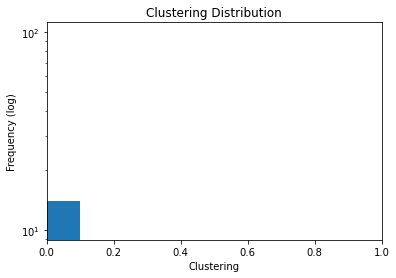


Average Distance:  1.8571428571428572
Diameter:  2


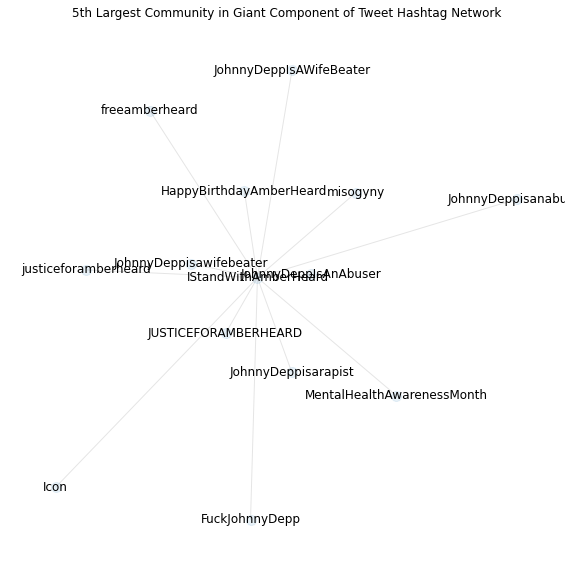

In [131]:
# Choose nth_comm, representing the community to be plotted

nth_comm = 134
comm_nodes = [node for node, comm in dict(gc_partition).items() if comm==nth_comm]

hashtag_GC_subgraph = hashtag_GC.subgraph(comm_nodes).copy()

N = hashtag_GC_subgraph.order()
L = hashtag_GC_subgraph.size() 

print(f'{n}th Largest Community of Giant Component:')
print ('Nodes: ', N)
print ('Edges: ', L)
print('Is Network Connected?', nx.is_connected(hashtag_GC_subgraph))

clustering = [c for c in nx.clustering(hashtag_GC_subgraph).values()]

c_min = np.min(clustering)
c_max = np.max(clustering);
c_avg = nx.average_clustering(hashtag_GC_subgraph)

print()
print ('Minimum clustering: ', c_min)
print ('Maximum clustering: ', c_max)
print ('Average clustering: ', c_avg)

s_clusters = pd.Series(clustering)

fig, ax = plt.subplots()
s_clusters.plot(kind='hist', ax=ax)
ax.set_xlim(0, 1)
ax.set_xlabel('Clustering')
ax.set_ylabel('Frequency (log)')
plt.yscale('log')
plt.title('Clustering Distribution')
plt.show()

D = nx.average_shortest_path_length(hashtag_GC_subgraph)
D_max = np.max([list(i.values())
                for i in dict(nx.shortest_path_length(hashtag_GC_subgraph)).values()])

print()
print ('Average Distance: ', D)
print ('Diameter: ', D_max)

# pos = nx.kamada_kawai_layout(hashtag_GC_subgraph)
# pos = nx.spring_layout(hashtag_GC_subgraph)
pos = nx.fruchterman_reingold_layout(hashtag_GC_subgraph)
# pos = nx.circular_layout(hashtag_GC_subgraph)

plt.figure(figsize=(10, 10))

plt.axis("off")
nx.draw_networkx_nodes(hashtag_GC_subgraph, pos, node_size=100, node_color='tab:blue', alpha=0.10)
nx.draw_networkx_edges(hashtag_GC_subgraph, pos, alpha=0.10)
nx.draw_networkx_labels(hashtag_GC_subgraph, pos, font_color="black")
plt.title(f'{n}th Largest Community in Giant Component of Tweet Hashtag Network')
plt.show()

#### From Top Co-occurring Hashtags in Giant Component

Top 30 Hashtags
Nodes: 30
Edges: 390


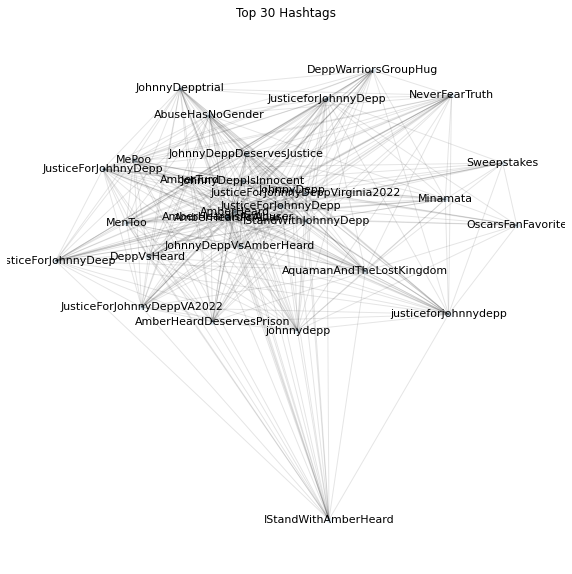

In [133]:
top_hashtag_num = 30

top_hashtags = all_hashtags.value_counts().iloc[:top_hashtag_num].index.to_list()

hashtag_top_G = hashtag_GC.subgraph(top_hashtags).copy()

print(f'Top {top_hashtag_num} Hashtags')
print('Nodes:', len(hashtag_top_G.nodes()))
print('Edges:', len(hashtag_top_G.edges()))


# pos = nx.kamada_kawai_layout(hashtag_top_G)
# pos = nx.spring_layout(hashtag_top_G)
pos = nx.fruchterman_reingold_layout(hashtag_top_G)
# pos = nx.circular_layout(hashtag_top_G)

plt.figure(figsize=(10, 10))

plt.axis("off")
nx.draw_networkx_nodes(hashtag_top_G, pos, node_size=20, node_color='tab:blue', alpha=0.1)
nx.draw_networkx_edges(hashtag_top_G, pos, alpha=0.10)
nx.draw_networkx_labels(hashtag_top_G, pos, font_color="black", font_size=11)
plt.title(f'Top {top_hashtag_num} Hashtags')
plt.show()